In [126]:
import sys

import gc
import json
# import gputil as gp
import psutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
import time
import xgboost as xgb
import tensorflow.keras.backend as K

from ahrs.filters import Madgwick, Mahony
from pprint import pprint
from scipy import signal
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, RepeatVector, TimeDistributed, Dense, Reshape, UpSampling1D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adamax, Adam, RMSprop, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2, l1

## Dataset Matching/Labeling

We have **2 data sources** that we need to match:
1. Built-in parameters data that contain the anomaly labels.
2. Nicla Sense ME data where we apply the anomaly detection algorithms.

We should correctly match the anomalous labels we got from the 1st data to 2nd.

#### The reasons for the mismatch in data sources:
1. Even thought we set both freqs to 20Hz with the given available libraries, we see that the freqs differ around **18Hz to 22Hz**.
2. The Nicla stopped **after the industrial robotic arm** (estimatedly few minutes.)
3. The Nicla **started earlier** than the industrial robotic arm.

If the freq was exactly **20Hz**, we would had **1728000** data points after 24 hours.

Now we match the data sources based on the **location of the first anomalous point**.

First we check Nicla Dataset.

In [5]:
# Generate Nicla dataframe, perform initial checks.
# If local the path:
nicla_path = "../datasets/nicla.csv"

# We skip first 6 rows due to faulty format/data.
nicla = pd.read_csv(nicla_path, on_bad_lines='warn', skiprows=6, 
                    names=["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagX", "MagY", "MagZ"])

# Check if there are any empty/Nan variables. 
if nicla.isnull().values.any():
    raise ValueError("Nan variable is present.")

# Explore the dataframe.
print(nicla.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751682 entries, 0 to 1751681
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   AccX    float64
 1   AccY    float64
 2   AccZ    float64
 3   GyroX   float64
 4   GyroY   float64
 5   GyroZ   float64
 6   MagX    float64
 7   MagY    float64
 8   MagZ    float64
dtypes: float64(9)
memory usage: 120.3 MB
None


We visualize **first 1000 points** to understand **when movement starts.**. We know the following:
 * The arm data are generated as soon as arm starts moving.
 * The Nicla starts generating data before the arm (few seconds).

 Thus, the initial Nicla data are **IDLE**, which we remove now.

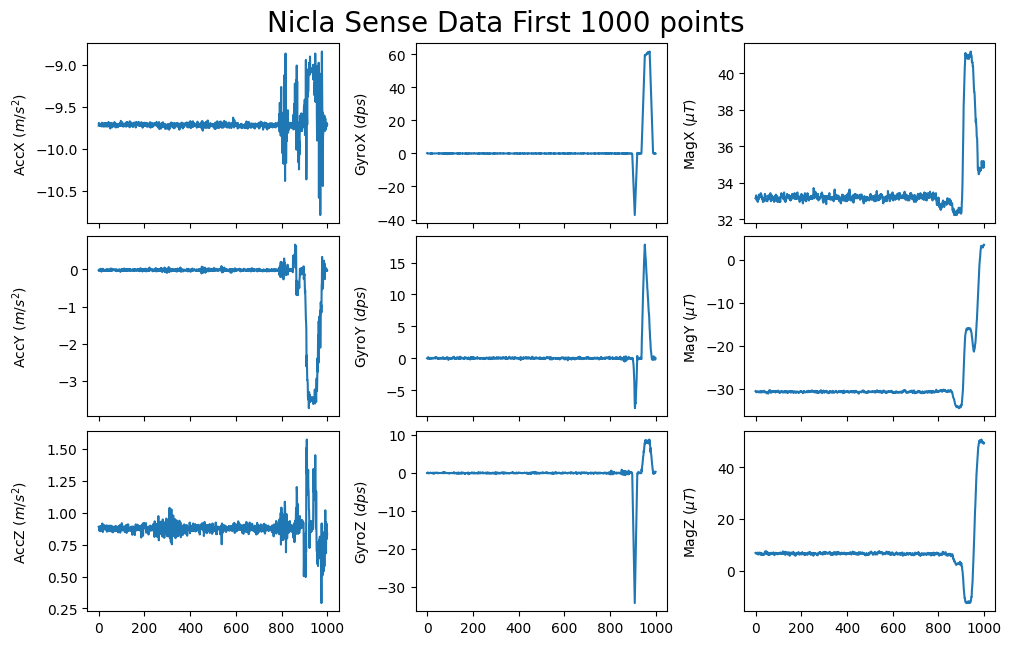

In [6]:
# Visualize the first 1000 point
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex = True, figsize=(10, 6), constrained_layout=True)

start_index = 0
end_index = 1000

ax1.plot(nicla.index[start_index:end_index], nicla['AccX'][start_index:end_index])
ax1.set_ylabel(r'AccX $(m/s^2)$')

ax2.plot(nicla.index[start_index:end_index], nicla['GyroX'][start_index:end_index])
ax2.set_ylabel(r'GyroX $(dps)$')

ax3.plot(nicla.index[start_index:end_index], nicla['MagX'][start_index:end_index])
ax3.set_ylabel(r'MagX (${\mu}T$)')

ax4.plot(nicla.index[start_index:end_index], nicla['AccY'][start_index:end_index])
ax4.set_ylabel(r'AccY $(m/s^2)$')

ax5.plot(nicla.index[start_index:end_index], nicla['GyroY'][start_index:end_index])
ax5.set_ylabel(r'GyroY $(dps)$')

ax6.plot(nicla.index[start_index:end_index], nicla['MagY'][start_index:end_index])
ax6.set_ylabel(r'MagY (${\mu}T$)')

ax7.plot(nicla.index[start_index:end_index], nicla['AccZ'][start_index:end_index])
ax7.set_ylabel(r'AccZ $(m/s^2)$')

ax8.plot(nicla.index[start_index:end_index], nicla['GyroZ'][start_index:end_index])
ax8.set_ylabel(r'GyroZ $(dps)$')

ax9.plot(nicla.index[start_index:end_index], nicla['MagZ'][start_index:end_index])
ax9.set_ylabel(r'MagZ (${\mu}T$)')

fig.align_labels()
plt.suptitle("Nicla Sense Data First 1000 points", x = 0.5, y = 1.05, fontsize = 20)
plt.show()

We see that the Nicla is idle for some time. We now find the **exact starting point**.

In [7]:
# We see that Gyro. noise occurs at range of 0 < x < 1, so we find the first point where x >= 1
index = np.argmax(nicla['GyroX'][:1000].diff().abs() >= 1)
print(f"The movement starts at {index}.")

The movement starts at 898.


As the movement starts at (roughly) 898th data point we can **remove the first 897 data points.**

In [8]:
nicla_dropped = nicla.iloc[897:].reset_index(drop=True)

Now, we load the **built-in arm dataset.**

In [9]:
%%time
# Generate df from dataset that contains labels/built-in parameters.
# Path for local PC.
right_arm_csv_path = "../datasets/right_arm.csv"

# Generate the dataframe.
right_arm = pd.read_csv(right_arm_csv_path, on_bad_lines='warn')

# Reset Timestamp to 0.
right_arm["Timestamp"] = right_arm["Timestamp"] - right_arm["Timestamp"][0]

CPU times: user 18 s, sys: 1.12 s, total: 19.1 s
Wall time: 19.1 s
CPU times: user 15.8 s, sys: 1.14 s, total: 17 s
Wall time: 17 s
CPU times: user 18 s, sys: 1.12 s, total: 19.1 s
Wall time: 19.1 s


In [10]:
# Get the lengths of nicla and arm data.
len_nicla_dropped = len(nicla_dropped)
len_right_arm = len(right_arm)

print(f"The length of the right arm data is {len_right_arm}")
print(f"The length of the nicla data is {len_nicla_dropped}")

The length of the right arm data is 1762650
The length of the nicla data is 1750785


As we see the lengths **do not match**. The **final point** of built-in dataset is an **anomaly**, that is how we can locate the **exact end of the 24 hour period.**

Now, we find the final **1** which corresponds to an anomaly.

In [11]:
# Find the final 1.
df_labels = right_arm["Anomaly State"]
index_list = np.where(df_labels == 1)
index_of_last_one = index_list[0][-1]
print(f"The final 1 is located at: {index_of_last_one}")

The final 1 is located at: 1728006


We run the test for just a bit more than 24 hours, while setting operation to normal after 24 hours.

The final 1 is at 1728006, well, this makes sense, because the **24 hour data at 20Hz means 1728000 data points**. We only have **6 extra** data points in this case.

We now **match the datasets**.

Now we try to find corresponding points at Nicla.

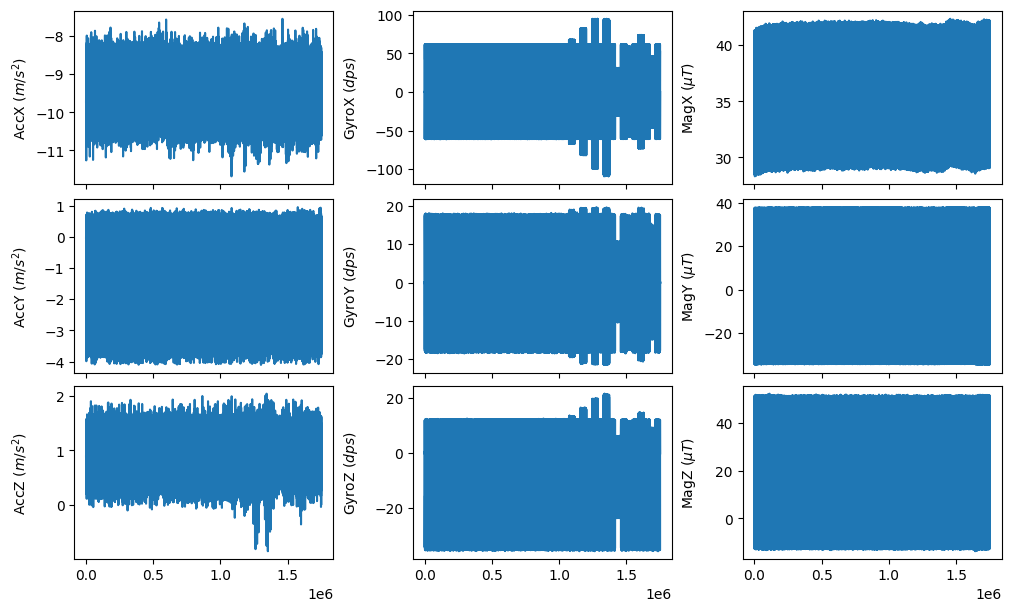

In [12]:
# Visualize the first 1000 point
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex = True, figsize=(10, 6), constrained_layout=True)

ax1.plot(nicla.index, nicla['AccX'])
ax1.set_ylabel(r'AccX $(m/s^2)$')

ax2.plot(nicla.index, nicla['GyroX'])
ax2.set_ylabel(r'GyroX $(dps)$')

ax3.plot(nicla.index, nicla['MagX'])
ax3.set_ylabel(r'MagX (${\mu}T$)')

ax4.plot(nicla.index, nicla['AccY'])
ax4.set_ylabel(r'AccY $(m/s^2)$')

ax5.plot(nicla.index, nicla['GyroY'])
ax5.set_ylabel(r'GyroY $(dps)$')

ax6.plot(nicla.index, nicla['MagY'])
ax6.set_ylabel(r'MagY (${\mu}T$)')

ax7.plot(nicla.index, nicla['AccZ'])
ax7.set_ylabel(r'AccZ $(m/s^2)$')

ax8.plot(nicla.index, nicla['GyroZ'])
ax8.set_ylabel(r'GyroZ $(dps)$')

ax9.plot(nicla.index, nicla['MagZ'])
ax9.set_ylabel(r'MagZ (${\mu}T$)')

fig.align_labels()
fig.savefig("../figures/niclaData.pdf", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

The anomalies are most obvious on **GyroX**, thus we utilize that feature for matching the datasets. 

We also compare the anomaly points seen in **arm** and the anomaly points seen in **Nicla**.

Now we will spot the first anomalous point on Nicla Data.

In [13]:
# Remove the rest of the data.
right_arm = right_arm[0:1728000]
# Check the anomaly labels.
df_anol = right_arm["Anomaly State"]
# Find the first anomaly point.
idx_f = (df_anol == 1.0).idxmax()

# Get the GyroX feature.
df_gyroX = nicla_dropped["GyroX"]
# Convert into numpy array.
gyroX = df_gyroX.to_numpy()
# Get first 1 m data points that we know its normal.
gyroX_1m = gyroX[0:1000000]
gyroX_1m_min = np.min(gyroX_1m)
gyroX_1m_max = np.max(gyroX_1m)

# Find the data either bigger than max or lower then min.
greater_indices = np.argwhere(gyroX > gyroX_1m_max)
lesser_indices = np.argwhere(gyroX < gyroX_1m_min)

first_greater = greater_indices[0][0]
first_lesser = lesser_indices[0][0]
last_greater = greater_indices[-1][0]
last_lesser = lesser_indices[-1][0]

print(f"The first greater than max at {first_greater}, the first lesser than min at {first_lesser}.")
print(f"The first anomaly point in Arm data seen at {idx_f}.")
print(f"The final anomaly point in Arm data seen at {index_of_last_one}.")
print(f"The final anomaly point in Nicla-Gyro data seen at {last_lesser}.")

The first greater than max at 1072794, the first lesser than min at 1072917.
The first anomaly point in Arm data seen at 1080004.
The final anomaly point in Arm data seen at 1728006.
The final anomaly point in Nicla-Gyro data seen at 1629872.


We start anomalies **after 15 hours** (corresponds to data point at **1080004**). 

However, when we manually try to label the Nicla data based on min-max thresholding the GyroX feature, anomalies seems to start at **1072794**.

Thus, we need to analyze further.

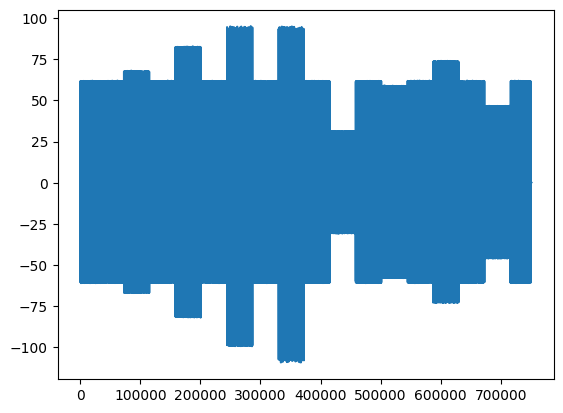

In [14]:
# Remove the first 1m points as we know they are normal.
gyroX_a_1m = gyroX[1000000:]
plt.plot(gyroX_a_1m)
plt.show()

Before matching labels, we need to filter the noise as the **data length will change**.

We apply **moving median filter** with fixed window size.

Then, we **manually** detect (error rate is < 1%) starting and ending points of anomaly event manually from the above graphs.
The anomalies are seen at below intervals (after 1m points):
1. **10% increase** at joint velocity between **72450 - 115125**.
1. **35% increase** at joint velocity between **158150 - 201100**.
1. **65% increase** at joint velocity between **244100 - 286875**.
1. **100% increase** at joint velocity between **329900 - 372650**.
1. **50% decrease** at joint velocity between **415700 - 458415**.
1. **5% decrease** at joint velocity between **501500 - 544725**.
1. **20% increase** at joint velocity between **587750 - 630150**.
1. **25% decrease** at joint velocity between **673200 - 716456 (the final anomaly)**.

We see that first anomaly is seen at 1072450 while the expected point is 1080000 if the data rate would be 20Hz.

1072450 corresponds to a data rate at 19.86Hz which explains the difference. The last point being at 1716456 also confirms this.

While one solution would be shifting the data based on this information, for the sake of accuracy we manually label the data.

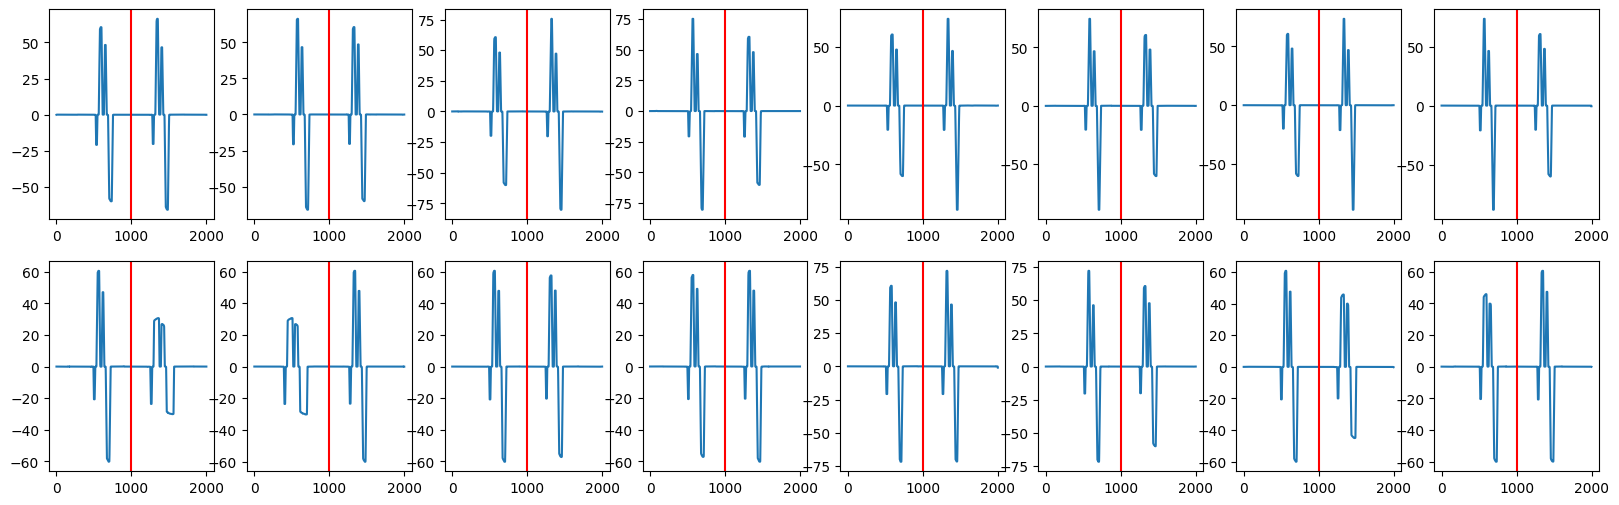

In [15]:
# Set window size for moving median.
f_window_size = 20

# Apply moving median and convert back to numpy array for faster ops.
nicla_filtered = nicla_dropped.rolling(f_window_size).median().dropna().to_numpy()

# Manually find the anomalous run.
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8), 
      (ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)) = plt.subplots(nrows=2, ncols=8, figsize=(20, 6))
# First jump seen at around 1072450.
ax1.plot(nicla_filtered[1071450:1073450, 3])
ax1.axvline(x=1000, color='red')
# First down seen at around 1115125.
ax2.plot(nicla_filtered[1114125:1116125, 3])
ax2.axvline(x=1000, color='red')
# Second jump seen at around 1158150.
ax3.plot(nicla_filtered[1157150:1159150, 3])
ax3.axvline(x=1000, color='red')
# Second down seen at around 1201100.
ax4.plot(nicla_filtered[1200100:1202100, 3])
ax4.axvline(x=1000, color='red')
# Third up seen at around 1244100.
ax5.plot(nicla_filtered[1243100:1245100, 3])
ax5.axvline(x=1000, color='red')
# Third down seen at around 1286875.
ax6.plot(nicla_filtered[1285875:1287875, 3])
ax6.axvline(x=1000, color='red')
# Fourth up seen at around 1329900.
ax7.plot(nicla_filtered[1328900:1330900, 3])
ax7.axvline(x=1000, color='red')
# Fourth down seen at around 1372650.
ax8.plot(nicla_filtered[1371675:1373675, 3])
ax8.axvline(x=1000, color='red')
# Fifth down seen at around 1415700.
ax9.plot(nicla_filtered[1414700:1416700, 3])
ax9.axvline(x=1000, color='red')
# Fifth up seen at around 1458415.
ax10.plot(nicla_filtered[1457415:1459415, 3])
ax10.axvline(x=1000, color='red')
# Sixth down seen at around 1501500.
ax11.plot(nicla_filtered[1500475:1502475, 3])
ax11.axvline(x=1000, color='red')
# Sixth up seen at around 1544725.
ax12.plot(nicla_filtered[1543725:1545725, 3])
ax12.axvline(x=1000, color='red')
# Seventh up seen at around 1587750.
ax13.plot(nicla_filtered[1586750:1588750, 3])
ax13.axvline(x=1000, color='red')
# Seventh down seen at around 1630150.
ax14.plot(nicla_filtered[1629150:1631150, 3])
ax14.axvline(x=1000, color='red')
# Eighth down seen at around 1673200.
ax15.plot(nicla_filtered[1672200:1674200, 3])
ax15.axvline(x=1000, color='red')
# Eighth up seen at around 1716450
ax16.plot(nicla_filtered[1715450:1717450, 3])
ax16.axvline(x=1000, color='red')


plt.show()

In [16]:
print(len(nicla_filtered))

1750766


The length of the Nicla Data 1750766


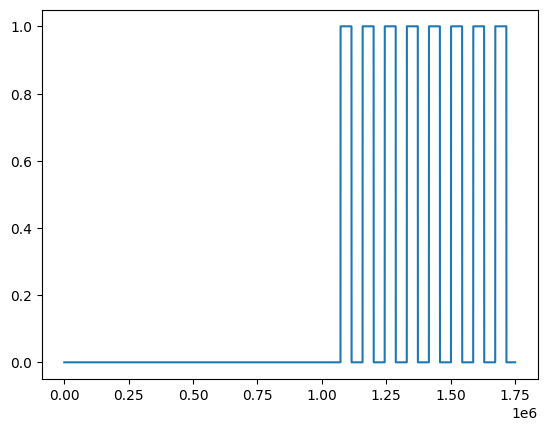

In [17]:
# Create a numpy array that will hold anomaly labels. 
len_nicla = len(nicla_filtered)
print(f"The length of the Nicla Data {len_nicla}")
nicla_labels = np.zeros((len_nicla, 1))
# Set anomaly points to ones.
nicla_labels[1072450:1115125] = 1 # 10% increase
nicla_labels[1158150:1201100] = 1 # 35% increase
nicla_labels[1244100:1286875] = 1 # 65% increase
nicla_labels[1329900:1372650] = 1 # 100% increase
nicla_labels[1415700:1458415] = 1 # 50% decrease
nicla_labels[1501500:1544725] = 1 # 5% decrease
nicla_labels[1587750:1630150] = 1 # 20% increase
nicla_labels[1673200:1716450] = 1 # 25% decrease
# Plot the labels for a visual check.
plt.plot(nicla_labels)
plt.show()

Now, we have our labels, so we split data into non-anomalous and anomalous.

Just to clarify, as you can see from the labels, **the anomalous run has both non-anomalous and anomalous operations.**

We know split our data based on this.

In [18]:
# Split the non-anomalous and anomalous data.
nicla_nor = nicla_filtered[:1072450] # 1072450 -> first anomalous point
nicla_anol = nicla_filtered[1072450:]
# We only need labels for anomalous run.
nicla_labels_anol = nicla_labels[1072450:]

# # Save the arrays
# np.save('../outputs/nicla_nor.npy', nicla_nor)
# np.save('../outputs/nicla_anol.npy', nicla_anol)
# np.save('../outputs/nicla_labels_anol.npy', nicla_labels_anol)

# # Provide download links
# nicla_nor_path = '../outputs/nicla_nor.npy'
# nicla_anol_path = '../outputs/nicla_anol.npy'
# nicla_labels_anol_path = '../outputs/nicla_labels_anol.npy'
# Save the arrays
np.save('../outputs/nicla_nor.npy', nicla_nor)
np.save('../outputs/nicla_anol.npy', nicla_anol)
np.save('../outputs/nicla_labels_anol.npy', nicla_labels_anol)

# Provide download links
nicla_nor_path = '../outputs/nicla_nor.npy'
nicla_anol_path = '../outputs/nicla_anol.npy'
nicla_labels_anol_path = '../outputs/nicla_labels_anol.npy'

print(f"Length of non-anomalous run {len(nicla_nor)}")
print(f"Length of anomalous run {len(nicla_anol)}")
print(f"Length of labels {len(nicla_labels_anol)}")

Length of non-anomalous run 1072450
Length of anomalous run 678316
Length of labels 678316


## Correlation Analysis

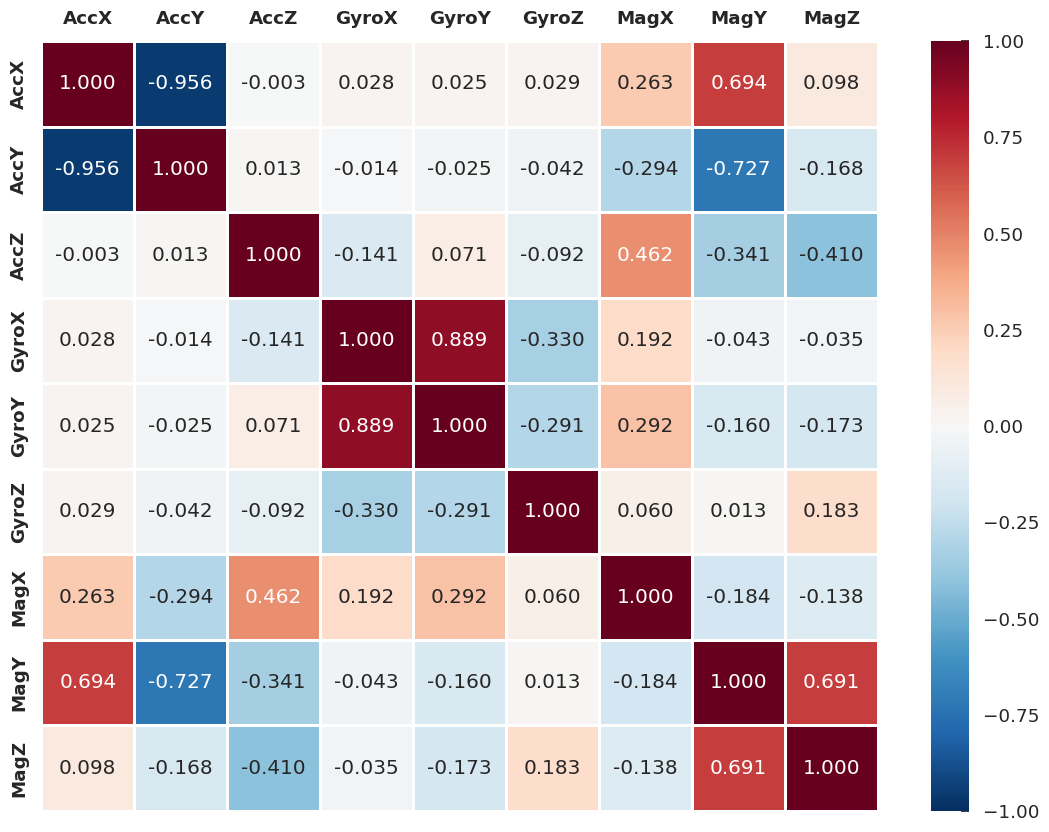

In [19]:
def cal_corr(arr):
    """
    Calculates the pearson correlation coefficient of given numpy arrays.
    Args:
        arr (list): A list containing numpy arrays.
    Returns:
        numpy_ndarray: A matrix that contains correlation coefficients.
    """
    corr_matrix = np.corrcoef(arr)
    return corr_matrix

# Split the features to single arrays.
np_accX = nicla_nor[:, 0]
np_accY = nicla_nor[:, 1]
np_accZ = nicla_nor[:, 2]
np_gyroX = nicla_nor[:, 3]
np_gyroY = nicla_nor[:, 4]
np_gyroZ = nicla_nor[:, 5]
np_magX = nicla_nor[:, 6]
np_magY = nicla_nor[:, 7]
np_magZ = nicla_nor[:, 8]

# Combine the features per modality.
np_acc = np.stack([np_accX, np_accY, np_accZ], axis=1)
np_gyro = np.stack([np_gyroX, np_gyroY, np_gyroZ], axis=1)
np_mag = np.stack([np_magX, np_magY, np_magZ], axis=1)

# Set tick labels.
tick_labels = ["AccX", "AccY", "AccZ",
               "GyroX", "GyroY", "GyroZ",
               "MagX", "MagY", "MagZ"]
# Check how input features correlate with each other.
corr_mat = cal_corr([np_accX, np_accY, np_accZ, 
                     np_gyroX, np_gyroY, np_gyroZ, 
                     np_magX, np_magY, np_magZ])

plt.figure(figsize=(13.5, 10))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mat, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=True, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=tick_labels, yticklabels=tick_labels)

# Get the colorbar object.
cbar = ax.collections[0].colorbar
# Set the location of the colorbar ticks to the right.
cbar.ax.yaxis.set_tick_params(pad=10, direction='in', labelright=True, labelleft=False)

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('../figures/corr_heatmap_IMU.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

Based on the above matrix, the highest correlated features in order are:
1. AccX and AccY with pcc = **-0.956** 
2. GyroX and GyroY with pcc = **0.889**
3. AccY and MagY with pcc = **-0.727**  

When pcc > 0.7 or pcc < -0.7, we accept that as a strong correlation. In this case, features of GyroX and GyroY, AccY and MagY seems to highly correlate.

Even though, the **single features might not correlate**, sets of features can. Now we check if accelerometer, gyroscrope and magnetometer data correlate with each other.

To find how sets of features correlate we apply **canonical-correlation analysis (CCA)**.

In [20]:
# Standardize with zero mean and unit variance / only normal data.
scaler = StandardScaler() 
acc_sc = scaler.fit_transform(np_acc)
gyro_sc = scaler.fit_transform(np_gyro) 
mag_sc = scaler.fit_transform(np_mag) 

# Apply CCA. 
n_comp = 3
cca_1 = CCA(scale=False, n_components=n_comp)
cca_2 = CCA(scale=False, n_components=n_comp)
cca_3 = CCA(scale=False, n_components=n_comp)
cca_1.fit(acc_sc, gyro_sc)
cca_2.fit(acc_sc, mag_sc)
cca_3.fit(gyro_sc, mag_sc)
acc_c_1, gyro_c_1 = cca_1.transform(acc_sc, gyro_sc)
acc_c_2, mag_c_1 = cca_2.transform(acc_sc, mag_sc)
gyro_c_2, mag_c_2 = cca_3.transform(gyro_sc, mag_sc)

# Canonical variate correlations.
acc_gyro_corr = [np.corrcoef(acc_c_1[:, i], gyro_c_1[:, i])[1][0] for i in range(n_comp)]
acc_mag_corr = [np.corrcoef(acc_c_2[:, i], mag_c_1[:, i])[1][0] for i in range(n_comp)]
gyro_mag_corr = [np.corrcoef(gyro_c_2[:, i], mag_c_2[:, i])[1][0] for i in range(n_comp)]

print(f"Acc-Gyro cvc: {acc_gyro_corr}")
print(f"Acc-Mag cvc: {acc_mag_corr}")
print(f"Gyro-Mag cvc: {gyro_mag_corr}")

Acc-Gyro cvc: [0.4856142661636789, 0.07371715418811832, 0.02834430994559355]
Acc-Mag cvc: [0.9696214582282653, 0.5802248892976103, 0.27068518080662746]
Gyro-Mag cvc: [0.4117384040755246, 0.30430201562288056, 0.07603021337917858]


This confirms our previous per feature correlation analysis.

In this case, the **accelerometer and magnetometer** data highly correlate.

In [21]:
# We know our data at roughly 19.86Hz.
s_period = 1 / 19.86
mad_fil = Madgwick(sample_period=s_period)
mah_fil = Mahony(sample_period=s_period)
# Set the identity quaternion, so we accept as zero rotation.
q = np.empty((len(np_acc), 4))
q_mahony = np.empty((len(np_acc), 4))
q[0] = np.array([1.0, 0.0, 0.0, 0.0])
q_mahony[0] = np.array([1.0, 0.0, 0.0, 0.0])
# Calculate quaternions.
for i in range(1, len(np_acc)):
    q[i] = mad_fil.updateMARG(q[i-1], acc=np_acc[i-1], gyr=np_gyro[i-1], mag=np_mag[i-1])
    q_mahony[i] = mah_fil.updateMARG(q_mahony[i-1], acc=np_acc[i-1], gyr=np_gyro[i-1], mag=np_mag[i-1])

[[ 1.          0.01543437 -0.003104    0.31948101]
 [ 0.01543437  1.         -0.2838297  -0.02259608]
 [-0.003104   -0.2838297   1.          0.01661727]
 [ 0.31948101 -0.02259608  0.01661727  1.        ]]
[[ 1.          0.46047982  0.93099665 -0.61002263]
 [ 0.46047982  1.          0.17652929 -0.83840541]
 [ 0.93099665  0.17652929  1.         -0.4621761 ]
 [-0.61002263 -0.83840541 -0.4621761   1.        ]]


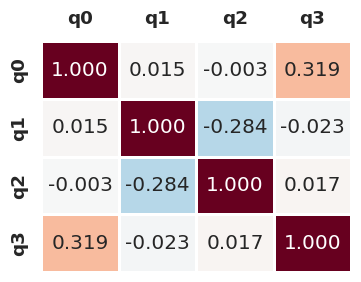

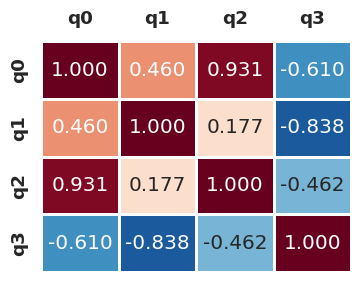

In [22]:
# Split the features to single arrays.
q_0 = q[:, 0]
q_1 = q[:, 1]
q_2 = q[:, 2]
q_3 = q[:, 3]
q_mahony_0 = q_mahony[:, 0]
q_mahony_1 = q_mahony[:, 1]
q_mahony_2 = q_mahony[:, 2]
q_mahony_3 = q_mahony[:, 3]

# Check how input features correlate with each other.
corr_mad = cal_corr([q_0, q_1, q_2, q_3])
corr_mah = cal_corr([q_mahony_0, q_mahony_1, q_mahony_2, q_mahony_3])
print(corr_mad)
print(corr_mah)

# Visualize the correlation map of Madgwick.
q_tick_labels = ["q0", "q1", "q2", "q3"]
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mad, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=False, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=q_tick_labels, yticklabels=q_tick_labels)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('../figures/corr_heatmap_madgwick.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Visualize the correlation map of Mahony.
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mah, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=False, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=q_tick_labels, yticklabels=q_tick_labels)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('../figures/corr_heatmap_mahony.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

The quaternions of Madgwick do not highly correlate.

The highly correlated quaternion features of **Mahony** filtering are:
1. **q0** and **q2** with pcc = **0.931**
2. **q1** and **q3** with pcc = **-0.838**

The quaternions generated via Mahony seems to correlate more than Madgwick generated ones.

This makes **Madgwick** more suitable for the regression analysis.

## Anomaly Detection
### Null Model (Always Yes)
1 means anomaly, 0 means normal.

In [23]:
# Count the number of actual anomalies (1s)
num_anomalies = np.sum(nicla_labels_anol)

# Calculate the total number of instances
total_instances = nicla_labels_anol.size

# Recall is 1.0 because we are predicting all instances as anomalies
recall = 1.0

# Precision is the number of true positives divided by the total number of predicted positives
# Here, predicted positives are equal to the total number of instances
precision = num_anomalies / total_instances

# F1 Score is 2 times the product of precision and recall divided by the sum of precision and recall
f1_score_null = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy when predicting all as anomalies: {precision}")
print(f"Recall when predicting all as anomalies: {recall}")
print(f"Precision when predicting all as anomalies: {precision}")
print(f"F1 Score when predicting all as anomalies: {f1_score_null}")
print(f"F1 Score when predicting all as anomalies: {f1_score_null}")

# True Positives (TP) is equal to the actual anomalies
tp = num_anomalies

# False Positives (FP) is the total number of normal instances (0s)
fp = total_instances - num_anomalies

# FPR is the ratio of FP to the sum of FP and TN
# Since TN is 0 in this case (as all instances are predicted as positive), FPR = FP / (FP + TN) = FP / FP = 1
fpr = fp / (fp + 0)

print(f"False Positive Rate when predicting all as anomalies: {fpr}")
print(f"F1 Score when predicting all as anomalies: {f1_score_null}")

Accuracy when predicting all as anomalies: 0.5052807246180246
Recall when predicting all as anomalies: 1.0
Precision when predicting all as anomalies: 0.5052807246180246
F1 Score when predicting all as anomalies: 0.6713441770089006
F1 Score when predicting all as anomalies: 0.6713441770089006
False Positive Rate when predicting all as anomalies: 1.0
F1 Score when predicting all as anomalies: 0.6713441770089006


## Baseline

In [24]:
# Find autocorrelation example.
def df_autocorr(df, lag=1, axis=0):
    """
    Compute the full-sample column-wise autocorrelation for a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    lag : int, optional (default=1)
        The lag at which to compute the autocorrelation.
    axis : int, optional (default=0)
        The axis along which to compute the autocorrelation.

    Returns:
    --------
    pandas.Series
        A Series containing the autocorrelation coefficients for each column of the input DataFrame.
    """
    return df.apply(lambda col: col.autocorr(lag), axis=axis)

def df_rolling_autocorr(df, window, lag=1):
    """
    Compute the rolling column-wise autocorrelation for a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    window : int
        The size of the rolling window.
    lag : int, optional (default=1)
        The lag at which to compute the autocorrelation.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the rolling autocorrelation coefficients for each column of the input DataFrame.
    """

    return (df.rolling(window=window)
        .corr(df.shift(lag)))

def df_autocorr_highest(df, window_min, window_max, lag_f):
    """
    Compute the highest mean correlation with respect to window length for each column of a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    window_min : int
        The minimum window size to consider.
    window_max : int
        The maximum window size to consider.
    lag_f : int
        The lag at which to compute the autocorrelation.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the highest mean correlation and corresponding window size for each column of the input DataFrame.
    """
    df_corrs = pd.DataFrame()
    df_corr_dict = {}
    for i in range(len(df.columns)):
        corr_init = 0
        corr_index = 0
        for j in range(window_min, window_max): 
            corr = df_rolling_autocorr(df.iloc[:,i], window=j, lag=lag_f).dropna().mean()
            if corr > corr_init:
                corr_init = corr
                corr_index = j
        corr_label = df.columns[i] + "_corr"    
        df_corrs[corr_label] = [corr_init, corr_index]
        df_corr_dict[corr_label] = [corr_init, corr_index]
    return df_corr_dict

# Set tick labels.
tick_labels = ["AccX", "AccY", "AccZ",
               "GyroX", "GyroY", "GyroZ",
               "MagX", "MagY", "MagZ"]

# First we find how anomalous part autocorrelates.
corr = df_autocorr_highest(pd.DataFrame(nicla_anol, columns=tick_labels), 600, 800, 1)
pprint(corr)

{'AccX_corr': [0.9957331570349306, 755],
 'AccY_corr': [0.9989057067106933, 753],
 'AccZ_corr': [0.97650084106174, 769],
 'GyroX_corr': [0.997800197516097, 758],
 'GyroY_corr': [0.9966574060862569, 756],
 'GyroZ_corr': [0.9951860194030435, 751],
 'MagX_corr': [0.9985353721251077, 756],
 'MagY_corr': [0.9996710646640955, 764],
 'MagZ_corr': [0.9991870812175039, 755]}


We see that due to the anomalies, this data **do not correlate** like non-anomalous data.

In [25]:
# Define non-scaled version.
IMU_non_scaled = np.hstack((np_acc, np_gyro, np_mag))

pd_IMU_data = pd.DataFrame(IMU_non_scaled, columns=tick_labels)

# Get sample start / end points.
s_start = 300000
s_end = 400000

# Find the window length that generates highest r (pearson correlation coefficient).
corr = df_autocorr_highest(pd_IMU_data[s_start:s_end], 600, 800, 1)
pprint(corr)

{'AccX_corr': [0.9956480501872034, 755],
 'AccY_corr': [0.9988926089826179, 755],
 'AccZ_corr': [0.9777193381788154, 755],
 'GyroX_corr': [0.9978351908182033, 755],
 'GyroY_corr': [0.9967375464573313, 755],
 'GyroZ_corr': [0.9952034562782655, 755],
 'MagX_corr': [0.9985234447917424, 755],
 'MagY_corr': [0.9996763904760192, 755],
 'MagZ_corr': [0.9991879996879954, 755]}


From the autocorrelation analysis, we see that data correlate highest when window length is **755**.

Data rate is ≈ 19.86Hz. So, **755** points correspond to **38 seconds**. During the test, we tried to set each arm's whole process to **40 seconds**. Thus, that is also confirmed by this analysis.

Our baseline methodology is simple:
   1. We know the periodicity. We set **periodicity to a window length** (755).
   2. We split whole dataset into input windows **with a period length**. 
   3. We generate two base windows via calculating the **mean** and **median** non-anomalous input windows.
   4. We calculate **overall RMSE** for **mean** and **median**.
   
However, there is one challenge that we need to solve. Even though, the data highly correlates with 755 points, we see that there is a **gradually increasing lag** occurring between windows.

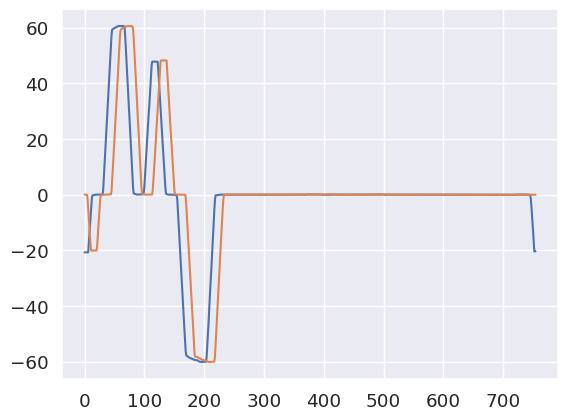

In [26]:
plt.plot(IMU_non_scaled[0:755:, 3])
plt.plot(IMU_non_scaled[755*100:755*101:, 3])
plt.show()

We need to **get rid of this lag** to come up with mean and median baseline windows.

First, we convert whole data to input windows and select random **three consecutive windows** to see if there is a lag.

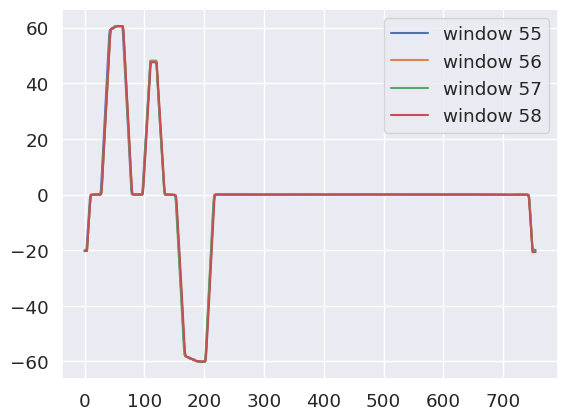

In [27]:
# Set window size.
window_size = 755
# We trim data in a way that it is exactly divided to 755.
# 1072100 data points mean 1420 windows.
IMU_cut = IMU_non_scaled[0:1072100]

# Reshape dataframe into an array of arrays with shape (1420, 755, 9).
n_windows = len(IMU_cut) // window_size

windows = np.empty((1420, 755, 9))
windows = IMU_cut[:n_windows * window_size].reshape(n_windows, window_size, -1)

# Plot windows.
plt.plot(windows[55][:, 3], label="window 55")
plt.plot(windows[56][:, 3], label="window 56")
plt.plot(windows[57][:, 3], label="window 57")
plt.plot(windows[58][:, 3], label="window 58")
plt.legend(loc="upper right")
plt.savefig('../figures/consecutive_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

As we see from above plot, the windows near-perfectly match. This confirms **the lag is near-zero** between consecutive windows.

Now we plot random **three random non-consecutive windows** to spot the lag.

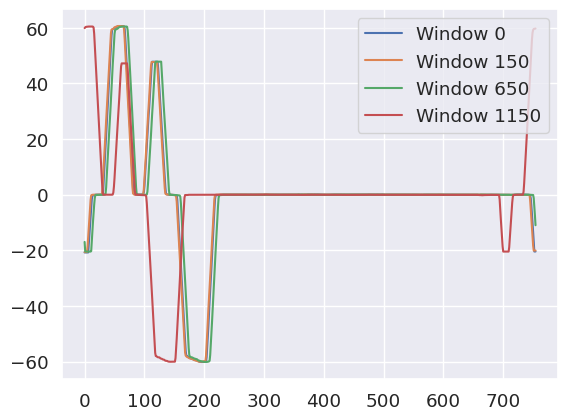

In [28]:
plt.plot(windows[0][0:755:, 3], label="Window 0")
plt.plot(windows[150][0:755, 3], label="Window 150")
plt.plot(windows[650][0:755, 3], label="Window 650")
plt.plot(windows[1150][0:755, 3], label="Window 1150")
plt.legend(loc="upper right")
plt.savefig('../figures/random_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

We see that, the **lag is more obvius as the gap between the windows increases.**

Now we **detect the lag of all consecutive windows** to confirm what we claimed above.

In [29]:
# Find lag of two consecutive windows.
lag_meds = []
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[j][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        # print(lag)
        lag_arr.append(lag)
    # print(lag_arr)
    lag_meds.append(np.median(lag_arr))
# Print the max, min lags.
print(min(lag_meds), max(lag_meds))

-3.0 3.0


We confirmed the lags between consecutive windows are **negligible as only ranges from -3 to 3 data points**.

Now, we find the lag of all windows to the **first window**.

In [30]:
# Find lag of all to first window.
lag_meds = []
lag_max = []
lag_mins = []
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[0][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        # print(lag)
        lag_arr.append(lag)
        
    lag_meds.append(np.median(lag_arr))
    lag_max.append(max(lag_arr))
    
# Print the max, min lags.
print(f"The min med: {min(lag_meds)}, the max med:{max(lag_meds)}")
print(f"The max:{max(lag_max)}")

The min med: -34.0, the max med:114.0
The max:121


In [30]:
# Find lag of all to first window.
lag_meds = []
lag_max = []
lag_mins = []
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[0][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        # print(lag)
        lag_arr.append(lag)
        
    lag_meds.append(np.median(lag_arr))
    lag_max.append(max(lag_arr))
    
# Print the max, min lags.
print(f"The min med: {min(lag_meds)}, the max med:{max(lag_meds)}")
print(f"The max:{max(lag_max)}")

The min med: -34.0, the max med:114.0
The max:121


This proves that the window sampling based on just **pearson correlation analysis** becomes inadequate when there are high number of near-zero values (this is our guess, need further analysis) are present within the data.

Now, **we will get rid of the lags and align all windows to the first window to come up with a stronger baseline.**

In [31]:
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[0][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        lag_arr.append(lag)
    
    # Get the lag median.
    w_lag = np.median(lag_arr)
    
    # Append/Prepend the base window's points
    if int(w_lag) < 0:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][int(w_lag):]
        # Get the part of the window that aligns with base window.
        cut_window = windows[j+1][(-1*int(w_lag)):755]
        cut_window = np.concatenate((cut_window, points_diff), axis=0)
        windows[j+1] = cut_window
    elif int(w_lag) == 0:
        pass
    else:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][0:int(w_lag)]
        # Get the part of the window that aligns with base window.
        cut_window = windows[j+1][0:(755-int(w_lag))]
        cut_window = np.concatenate((points_diff, cut_window), axis=0)
        windows[j+1] = cut_window

Now, that all windows are aligned, **we generate the mean/median windows to be used as stronger baselines.** 

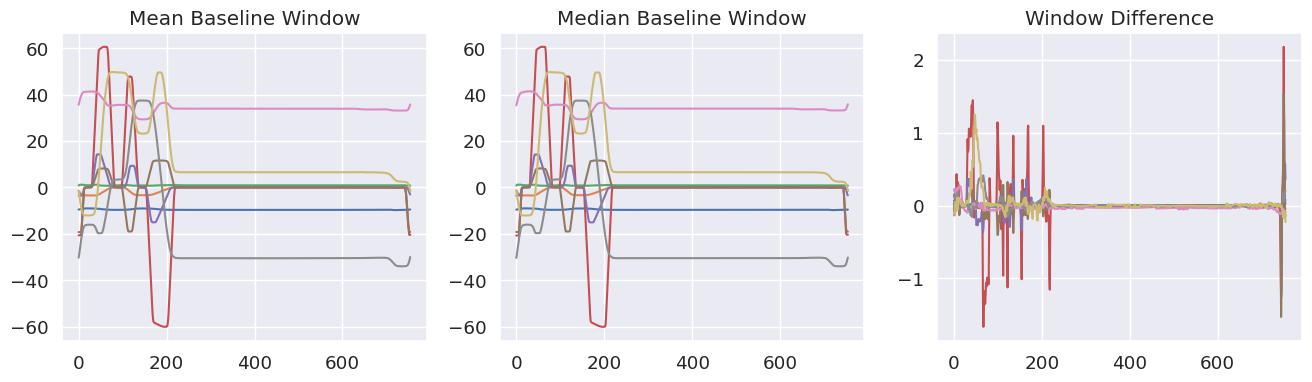

In [32]:
# Get the stronger mean/medians as baselines.
mean_window = np.mean(windows, axis=0)
median_window = np.median(windows, axis=0)

# Find difference between two windows.
diff_window = mean_window - median_window
# Visualise the baselines
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(mean_window)
ax2.plot(median_window)
ax3.plot(diff_window)
ax1.set_title("Mean Baseline Window")
ax2.set_title("Median Baseline Window")
ax3.set_title("Window Difference")
plt.savefig('../figures/baseline_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [33]:
sum_rmse_mean = 0
sum_rmse_median = 0
# Sum the RMSEs per feature.
for window in windows:
    rmse_mean = np.sqrt(np.mean((window - mean_window)**2, axis=0))
    rmse_median = np.sqrt(np.mean((window - median_window)**2, axis=0))
    sum_rmse_mean += rmse_mean
    sum_rmse_median += rmse_median
mean_per_feature = sum_rmse_mean / windows.shape[0]
median_per_feature = sum_rmse_median / windows.shape[0]
overall_mean_rmse = np.mean(mean_per_feature)
overall_median_rmse = np.mean(median_per_feature)
print(f"Mean RMSE per feature: {mean_per_feature}")
print(f"Median RMSE per feature: {median_per_feature}")
print(f"Overall mean RMSE: {overall_mean_rmse}")
print(f"Overall median RMSE: {overall_median_rmse}")

Mean RMSE per feature: [0.04278741 0.07058257 0.02718    1.27839048 0.29570638 0.50613047
 0.20503904 0.49432547 0.59824453]
Median RMSE per feature: [0.04314793 0.0714159  0.028084   1.31436817 0.30415338 0.51580648
 0.20815076 0.50062956 0.61386907]
Overall mean RMSE: 0.3909318160524488
Overall median RMSE: 0.39995836045971617


We see that **mean as a baseline beats the median**, hence we will be using **mean baseline** from now on.

Now we will **detect anomalies via the mean baseline**. First, we generate the anomalous windows and check if they align with the baseline.

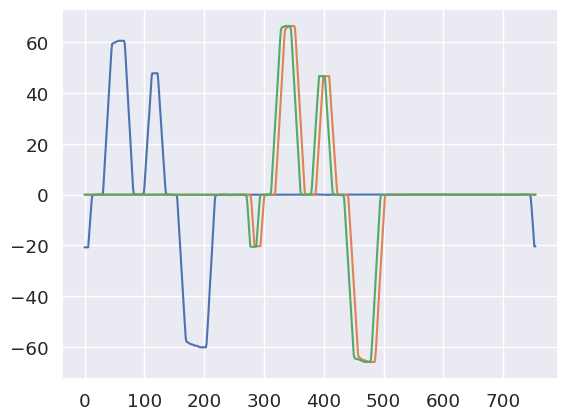

In [34]:
# Get the length of the anomalies
n_anol = len(nicla_anol)
# We cut in a way that it is exactly divided to window size.
anol_cut = nicla_anol[:677990]
# Reshape dataframe into an array of arrays with shape (852, 755, 9).
n_anol_windows = len(anol_cut) // window_size
windows_anol = np.empty((898, 755, 9))
windows_anol = anol_cut[:n_windows * window_size].reshape(n_anol_windows, window_size, -1)

# Compare random windows with the baseline window.
plt.plot(windows[0][:, 3])
plt.plot(windows_anol[0][:, 3])
plt.plot(windows_anol[1][:, 3])
plt.show()

We see that **anomalous windows are not aligned**. They neither align with the base window nor each other.

Now **we align them.**

In [35]:
for j in range(n_anol_windows):
    lag_arr = []
    for i in range(windows_anol.shape[2]):
        x = windows[0][:, i]
        y = windows_anol[j][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        lag_arr.append(lag)
    
    # Get the lag median.
    w_lag = np.median(lag_arr)
    
    # Append/Prepend the base window's points
    if int(w_lag) < 0:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][int(w_lag):]
        # Get the part of the window that aligns with base window.
        cut_window = windows_anol[j][(-1*int(w_lag)):755]
        cut_window = np.concatenate((cut_window, points_diff), axis=0)
        windows_anol[j] = cut_window
    elif int(w_lag) == 0:
        pass
    else:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][0:int(w_lag)]
        # Get the part of the window that aligns with base window.
        cut_window = windows_anol[j][0:(755-int(w_lag))]
        cut_window = np.concatenate((points_diff, cut_window), axis=0)
        windows_anol[j] = cut_window

We **plot the random anomalous windows** to see if windows are aligned.

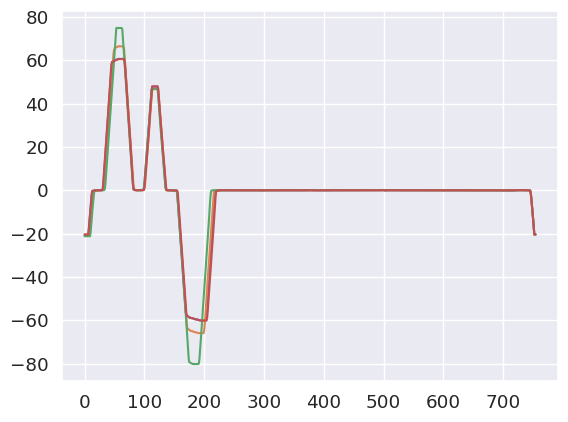

In [36]:
plt.plot(windows[0][:, 3])
plt.plot(windows_anol[0][:, 3])
plt.plot(windows_anol[150][:, 3])
plt.plot(windows_anol[-1][:, 3])
plt.show()

Due to data having anomalies, we work with **non-normalized/standardized** data until now as **anomalies affect the standardization/normalization**. There are robust methods are available but these are not utilized under the context of anomaly detection, as we want our anomalies to stay as they are here.

However, this creates an issue during the RMSE calculation (thresholding), due to data being on different scales, **one feature's noise might contribute RMSE more than the anomaly of an another feature.**

The feature scales are shown below.

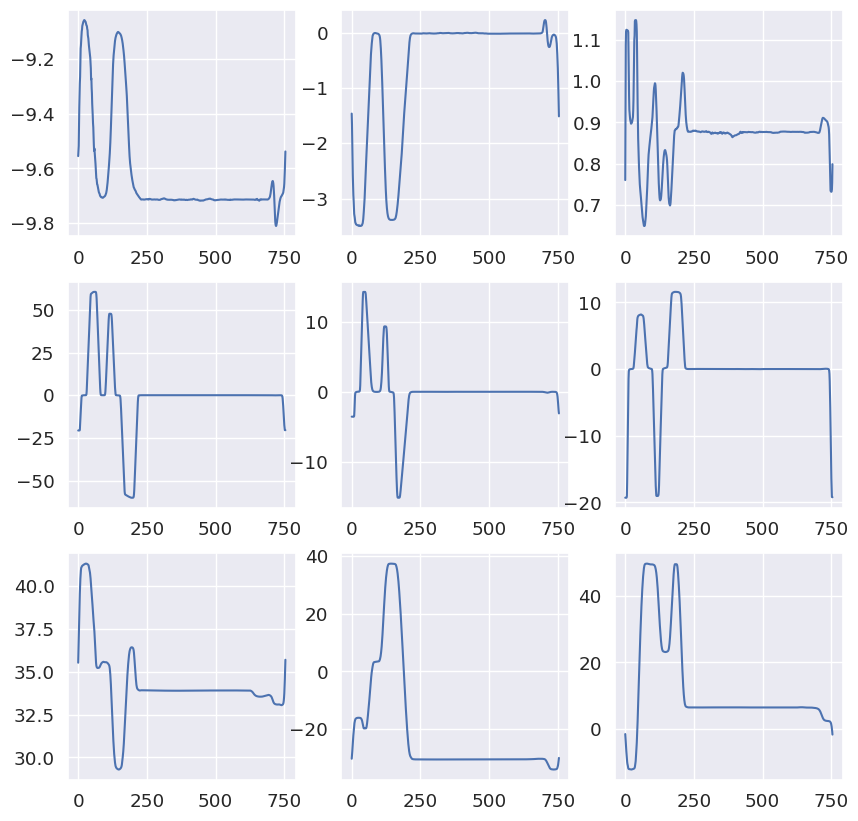

In [37]:
# Create a 3 x 3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# Flatten the axs array for easy indexing.
axs = axs.flatten()
for i in range(mean_window.shape[1]):
    axs[i].plot(mean_window[:, i])
plt.show()

For this reason, we **min-max normalize** the windows before calculating the RMSE.

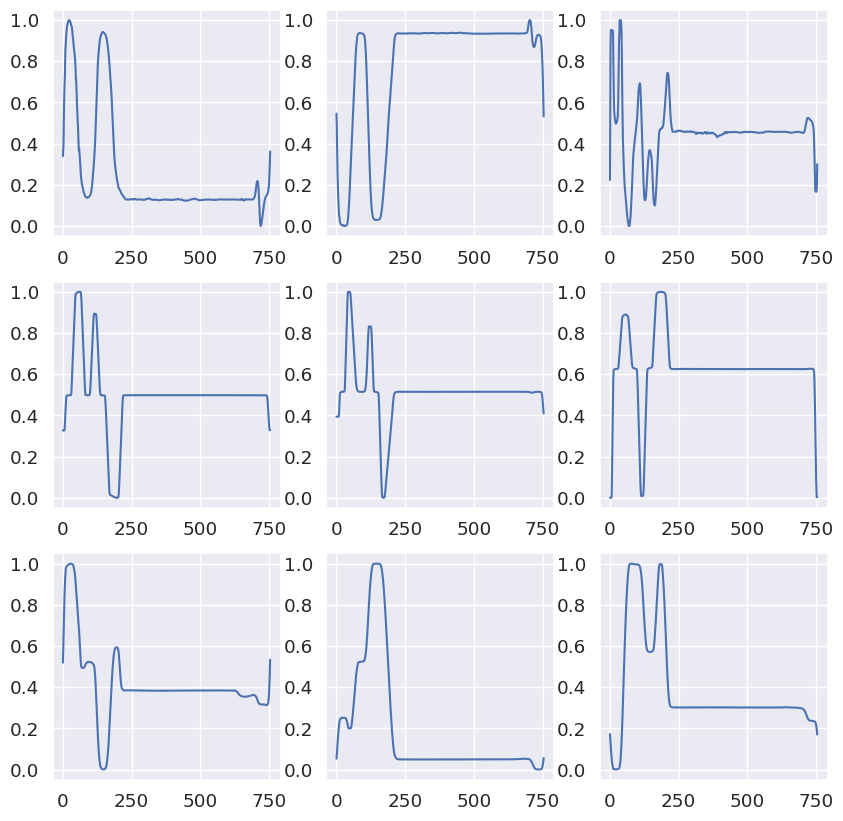

In [38]:
# Initialize a MinMaxScaler object.
scaler_mm = MinMaxScaler()

# Apply the scaler to the data.
scaler_mm.fit(mean_window)

# Scale the data.
mean_window_mm = scaler_mm.transform(mean_window)

# Create a 3 x 3 grid of subplots for scaled data.
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# Flatten the axs array for easy indexing.
axs = axs.flatten()
for i in range(mean_window_mm.shape[1]):
    axs[i].plot(mean_window_mm[:, i])
plt.show()

Now, calculate RMSE of the windows and mean baseline window.

We utilize RMSE for the following reasons.
   1. The RMSE has the same unit as the input, hence **more interpretable**. 
   2. RMSE is more **robust against extreme anomalies and noise**. These two are common in data generated by IMU sensors.

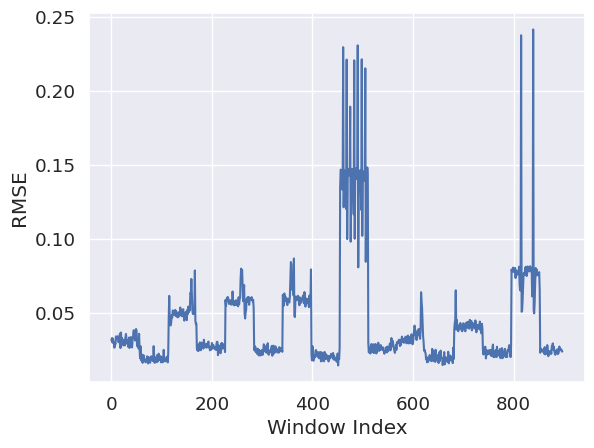

Total processing time: 0.16141343116760254 seconds
Average processing time per window: 0.00017974769617773112 seconds
Total processing time: 0.11151432991027832 seconds
Average processing time per window: 0.00012418076827425202 seconds
Total processing time: 0.16141343116760254 seconds
Average processing time per window: 0.00017974769617773112 seconds


In [40]:
# rmse_anols = []
# # Calculate the RMSEs per feature.
# for window in windows_anol:
    
#     # Normalize the window via the mean window fit.
#     anol_scaled = scaler_mm.transform(window)

#     # 1 (anomaly) if rmse >= mean_rmse, else otherwise.
#     rmse = np.mean(np.sqrt(np.mean((anol_scaled - mean_window_mm)**2, axis=0)))
#     rmse_anols.append(rmse)
    
# plt.plot(rmse_anols)
# plt.show()

# Start the timer
start_time = time.time()

rmse_anols = []

# Calculate the RMSEs per feature for each window
for window in windows_anol:
    
    # Normalize the window via the mean window fit
    anol_scaled = scaler_mm.transform(window)

    # Calculate RMSE and append to the list
    rmse = np.mean(np.sqrt(np.mean((anol_scaled - mean_window_mm)**2, axis=0)))
    rmse_anols.append(rmse)

# Stop the timer
end_time = time.time()

# Calculate the total processing time
total_processing_time = end_time - start_time

# Calculate the average processing time per window
average_processing_time_per_window = total_processing_time / len(windows_anol)

# Plot RMSEs
plt.plot(rmse_anols)

# Plot RMSEs
plt.plot(rmse_anols)
plt.xlabel("Window Index")
plt.ylabel("RMSE")
# Plot RMSEs
plt.plot(rmse_anols)
plt.show()

print(f"Total processing time: {total_processing_time} seconds")
print(f"Average processing time per window: {average_processing_time_per_window} seconds")

We need to set our labels correctly, as the labels we have are one per point, but we need to label our windows.

We will accept the window as **anomalous if half or more than half of the window contains anomalous points**.

Then based on a **certain threshold (found via grid search)**, we will accept the RMSE window as anomaly or not.

Grid search is a labour intensive task, thus we only provide **the final search parameters below**.

In [41]:
# Similar to windowing previously, divideable to 755.
nicla_labels_anol_cut = nicla_labels_anol[:677990]

# Convert into windows.
label_windows = nicla_labels_anol_cut[:n_windows * window_size].reshape(n_anol_windows, window_size, -1)

# if sum is above 755/2 its anomaly.
# If sum is above 755/2, it's an anomaly.
# if sum is above 755/2 its anomaly.
label_final = []
for window in label_windows:
    if np.sum(window) > 755/2:
        label_final.append(1)
    else:
        label_final.append(0)

# Set a range of thresholds.
# We set the best one, feel free to play with these.
# We set the best one, feel free to play with these.
th = [x/10000 for x in range(200, 400, 1)]

best_f1 = 0
best_threshold = 0
best_results = {}

for threshold in th:
    y_pred = [1 if rmse >= threshold else 0 for rmse in rmse_anols]
    tn, fp, fn, tp = confusion_matrix(label_final, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    rec = tp / (tp + fn) if (tp + fn) != 0 else 0
    prec = tp / (tp + fp) if (tp + fp) != 0 else 0
    f1 = (2 * prec * rec) / (prec + rec) if (prec + rec) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_results = {'Threshold': threshold, 'Accuracy': acc, 'Recall': rec, 'Precision': prec, 'F1': f1}

best_results

{'Threshold': 0.0302,
 'Accuracy': 0.9576837416481069,
 'Recall': 0.933920704845815,
 'Precision': 0.9814814814814815,
 'F1': 0.9571106094808127}

## PLS

In [42]:
# Define a function to create a dataset with rolling windows
def create_dataset(data, window_size, step=1):
    X, y = [], []
    for i in range(0, len(data) - window_size - step + 1, step):
        X.append(data[i:(i + window_size)])  # Window of observations
        y.append(data[i + window_size])      # Next observation as target
    return np.array(X), np.array(y)

# Load the arrays: normal, and anomalous data, and labels.
nicla_nor = np.load('../outputs/nicla_nor.npy')
nicla_anol = np.load('../outputs/nicla_anol.npy')
nicla_labels_anol = np.load('../outputs/nicla_labels_anol.npy')

# Reduce the size of normal data to 10%
total_length = int(nicla_nor.shape[0] * 0.1)
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the reduced data (10% of original)
reduced_nor_data = nicla_nor[:total_length]
train_data = reduced_nor_data[:train_end]
validation_data = reduced_nor_data[train_end:val_end]
test_data = reduced_nor_data[val_end:]

# Scaling
scaler_X = StandardScaler().fit(train_data)
X_train = scaler_X.transform(train_data)
X_val = scaler_X.transform(validation_data)
X_test = scaler_X.transform(test_data)
X_anol = scaler_X.transform(nicla_anol)

# Split the data into input and target using the window size of 755
window_size = 755
X_train, y_train = create_dataset(X_train, window_size=window_size)
X_val, y_val = create_dataset(X_val, window_size=window_size)
X_test, y_test = create_dataset(X_test, window_size=window_size)
X_anol, y_anol = create_dataset(X_anol, window_size=window_size)

In [43]:
X_train.shape, y_train.shape

((63592, 755, 9), (63592, 9))

In [44]:
# Define the number of PLS components
n_components = 2

# Initialize the PLS model
pls_model = PLSRegression(n_components=n_components)

# Flatten the timesteps and features for each sample in X_train
X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Fit the model with the reshaped data
pls_model.fit(X_train_2d, y_train)

PLSRegression()

In [45]:
# Flatten validation and test data
X_val_2d = X_val.reshape(X_val.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
X_anol_2d = X_anol.reshape(X_anol.shape[0], -1)

# Predict on validation and test data
y_val_pred = pls_model.predict(X_val_2d)
y_test_pred = pls_model.predict(X_test_2d)

# Start timer
start_time = time.time()
# Predict on anomalous data
y_anol_pred = pls_model.predict(X_anol_2d)
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
total_samples_anol = X_anol_2d.shape[0]  # Total number of samples in anomalous data

# Calculate average inference time per sample
average_inference_time_per_sample = elapsed_time / total_samples_anol

print(f"Time taken for predicting on anomalous data: {elapsed_time} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample} seconds")

# Calculate RMSE for validation and test data
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate RMSE per row for anomalous data
rmse_anol_per_row = np.sqrt(np.mean((y_anol - y_anol_pred) ** 2, axis=1))

print(f"Validation RMSE: {rmse_val}")
print(f"Test RMSE: {rmse_test}")

Time taken for predicting on anomalous data: 28.277865886688232 seconds
Average inference time per sample: 4.173478976311835e-05 seconds
Time taken for predicting on anomalous data: 75.00440979003906 seconds
Average inference time per sample: 0.00011069764905305805 seconds
Time taken for predicting on anomalous data: 28.277865886688232 seconds
Average inference time per sample: 4.173478976311835e-05 seconds
Validation RMSE: 0.7077491220045599
Test RMSE: 0.7069148580651732


In [45]:
# Flatten validation and test data
X_val_2d = X_val.reshape(X_val.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
X_anol_2d = X_anol.reshape(X_anol.shape[0], -1)

# Predict on validation and test data
y_val_pred = pls_model.predict(X_val_2d)
y_test_pred = pls_model.predict(X_test_2d)

# Start timer
start_time = time.time()
# Predict on anomalous data
y_anol_pred = pls_model.predict(X_anol_2d)
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
total_samples_anol = X_anol_2d.shape[0]  # Total number of samples in anomalous data

# Calculate average inference time per sample
average_inference_time_per_sample = elapsed_time / total_samples_anol

print(f"Time taken for predicting on anomalous data: {elapsed_time} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample} seconds")

# Calculate RMSE for validation and test data
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate RMSE per row for anomalous data
rmse_anol_per_row = np.sqrt(np.mean((y_anol - y_anol_pred) ** 2, axis=1))

print(f"Validation RMSE: {rmse_val}")
print(f"Test RMSE: {rmse_test}")

Time taken for predicting on anomalous data: 28.277865886688232 seconds
Average inference time per sample: 4.173478976311835e-05 seconds
Time taken for predicting on anomalous data: 75.00440979003906 seconds
Average inference time per sample: 0.00011069764905305805 seconds
Time taken for predicting on anomalous data: 28.277865886688232 seconds
Average inference time per sample: 4.173478976311835e-05 seconds
Validation RMSE: 0.7077491220045599
Test RMSE: 0.7069148580651732


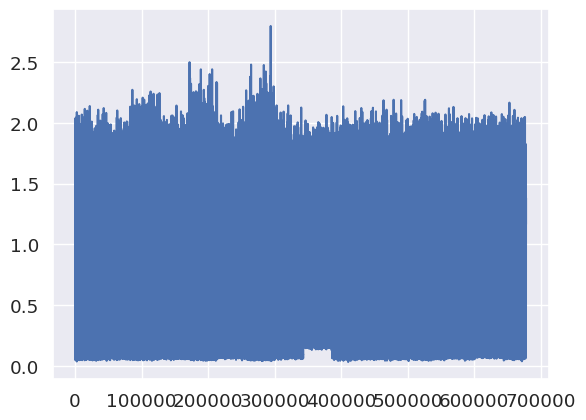

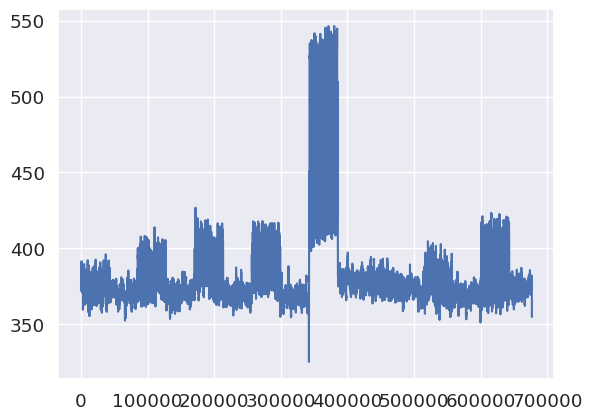

In [46]:
plt.plot(rmse_anol_per_row)
plt.show()
window_size = 755
rmse_sliding_sums = np.convolve(rmse_anol_per_row, np.ones(window_size), 'valid')
plt.plot(rmse_sliding_sums)
plt.show()

In [47]:
# Flatten array to 1D and create binary results
adjusted_labels = nicla_labels_anol[755:].ravel()
binary_result = np.convolve(adjusted_labels, np.ones(window_size), 'valid') > (755 / 2)
binary_result = binary_result.astype(int)

best_threshold = 0
best_metrics = {'F1': 0, 'Recall': 0, 'Precision': 0, 'Accuracy': 0, 'FPR': 0}

# Search for the best threshold
search_range = 10  # Narrower range around the initial best threshold
num_points = 200   # More points for finer granularity
lower_bound, upper_bound = max(rmse_sliding_sums.min(), best_threshold - search_range / 2), min(rmse_sliding_sums.max(), best_threshold + search_range / 2)
# Flatten array to 1D.
adjusted_labels = nicla_labels_anol[755:].ravel()  
binary_result = np.convolve(adjusted_labels, np.ones(window_size), 'valid') > (755 / 2)
binary_result = binary_result.astype(int)
print(f"The length of the labels: {len(binary_result)}")
print(f"The length of the windows: {len(rmse_sliding_sums)}")

best_threshold = 0
best_f1 = 0

# We find the best threshold.
for threshold in np.linspace(rmse_sliding_sums.min(), rmse_sliding_sums.max(), num=100):
    labeled_windows = (rmse_sliding_sums > threshold).astype(int)
    f1 = f1_score(binary_result, labeled_windows)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

search_range = 10  # Narrower range around the initial best threshold
num_points = 200   # More points for finer granularity

lower_bound = max(rmse_sliding_sums.min(), best_threshold - search_range / 2)
upper_bound = min(rmse_sliding_sums.max(), best_threshold + search_range / 2)

best_f1 = 0
best_recall = 0
best_precision = 0
best_accuracy = 0

for threshold in np.linspace(lower_bound, upper_bound, num=num_points):
    labeled_windows = (rmse_sliding_sums > threshold).astype(int)
    f1 = f1_score(binary_result, labeled_windows)
    recall = recall_score(binary_result, labeled_windows)
    precision = precision_score(binary_result, labeled_windows)
    accuracy = accuracy_score(binary_result, labeled_windows)
    fp = np.sum((labeled_windows == 1) & (binary_result == 0))
    tn = np.sum((labeled_windows == 0) & (binary_result == 0))
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    if f1 > best_metrics['F1']:
        best_metrics = {'Threshold': threshold, 'F1': f1, 'Recall': recall, 'Precision': precision, 'Accuracy': accuracy, 'FPR': fpr}

print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

Best Threshold: 323.46896833960005
Best F1 Score: 0.6708620748908843
Recall: 1.0
Precision: 0.5047347323535365
Accuracy: 0.5047347323535365
FPR: 1.0


## Sometimes, kernel might die, so we have everything ready for each method, you can directly start from running here.

In [52]:
# The below is necessary for starting core Python generated random numbers in a well-defined state.
random.seed(12345)

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(42)

# The below set_seed will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

## 1D-CNN

In [53]:
patience = 5
batch_size = 1024
sequence_stride = 1

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def anol(self):
    return self.make_dataset(self.anol_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, anol_df, label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.anol_df = anol_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.anol = anol
WindowGenerator.example = example

In [54]:
%%time
# Load the arrays
nicla_nor = np.load('../outputs/nicla_nor.npy')
nicla_anol = np.load('../outputs/nicla_anol.npy')
nicla_labels_anol = np.load('../outputs/nicla_labels_anol.npy')

# Calculate the indices for the split
total_length = len(nicla_nor)
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the data
train_data = nicla_nor[:train_end]
validation_data = nicla_nor[train_end:val_end]
test_data = nicla_nor[val_end:]

# Scaling
scaler_X = StandardScaler().fit(train_data)
X_train, X_val, X_test, X_anol = [pd.DataFrame(scaler_X.transform(data), 
                                  columns=["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagX", "MagY", "MagZ"]) 
                                  for data in [train_data, validation_data, test_data, nicla_anol]]

CONV_WIDTH = 5 # Kernel size.
MAX_EPOCHS = 100 # Can increase more for further analysis.
NUM_FILTERS = 32
MAX_POOL_SIZE = 3
NUM_FEATURES = 9
WINDOW_SIZE = 755 # This is output size.
OUT_SIZE = 1 # Gives the best result.

# Set neural network model/parameters.
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT_SIZE*NUM_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_SIZE, NUM_FEATURES])
])

val_performance = {}
loss = {}
val_loss = {}

cnn_model.build(input_shape=(None, 755, 9))
cnn_model.summary()

# Path to save the model.
model_path = "../models/1DCNN"

# Set window.
w_1dcnn = WindowGenerator(input_width=WINDOW_SIZE, label_width=OUT_SIZE, shift=OUT_SIZE,
                     train_df=X_train, val_df=X_val, test_df = X_test, anol_df = X_anol)

# Verify the model input/output shape.
print('Input shape:', w_1dcnn.example[0].shape)
print('Output shape:', cnn_model(w_1dcnn.example[0]).shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 751, 32)           1472      
                                                                 
 conv1d_1 (Conv1D)           (None, 747, 32)           5152      
                                                                 
 max_pooling1d (MaxPooling1  (None, 249, 32)           0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 245, 32)           5152      
                                                                 
 conv1d_3 (Conv1D)           (None, 241, 32)           5152      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 80, 32)            0         
 g1D)                                                   

2023-12-08 09:53:27.028684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46646 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


Input shape: (1024, 755, 9)


2023-12-08 09:53:27.895631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


Output shape: (1024, 1, 9)
CPU times: user 1.35 s, sys: 832 ms, total: 2.18 s
Wall time: 1.72 s
_________________________________________________________________
Input shape: (1024, 755, 9)
Output shape: (1024, 1, 9)
CPU times: user 807 ms, sys: 214 ms, total: 1.02 s
Wall time: 554 ms


In [55]:
# Train the model.
# Compile and evaluate.
history_1dcnn = compile_and_fit(cnn_model, w_1dcnn)

Epoch 1/100


2023-12-03 10:43:41.787054: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb7d4978d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-03 10:43:41.787098: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-12-03 10:43:41.791516: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-03 10:43:41.916138: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


628/628 [==============================] - 30s 42ms/step - loss: 0.0471 - root_mean_squared_error: 0.2170 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1602
Epoch 2/100
628/628 [==============================] - 26s 41ms/step - loss: 0.0240 - root_mean_squared_error: 0.1550 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1551
Epoch 3/100
628/628 [==============================] - 26s 41ms/step - loss: 0.0232 - root_mean_squared_error: 0.1522 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1524
Epoch 4/100
628/628 [==============================] - 26s 41ms/step - loss: 0.0227 - root_mean_squared_error: 0.1507 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1510
Epoch 5/100
628/628 [==============================] - 26s 41ms/step - loss: 0.0224 - root_mean_squared_error: 0.1495 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1501
Epoch 6/100
628/628 [==============================] - 26s 41ms/step - loss: 0.0221 - root_mean_squared_error: 0.1487 - val_loss: 0.0223 

**Save** or **load** the model based on your needs.

In [68]:
# Save the model.
# cnn_model.save("../models/1DCNN" + ".keras")

# Load the model.
cnn_model = load_model("../models/1DCNN.keras")
cnn_model.save("../models/1DCNN" + ".keras")

# Load the model.
# cnn_model = load_model("../models/1DCNN.keras")

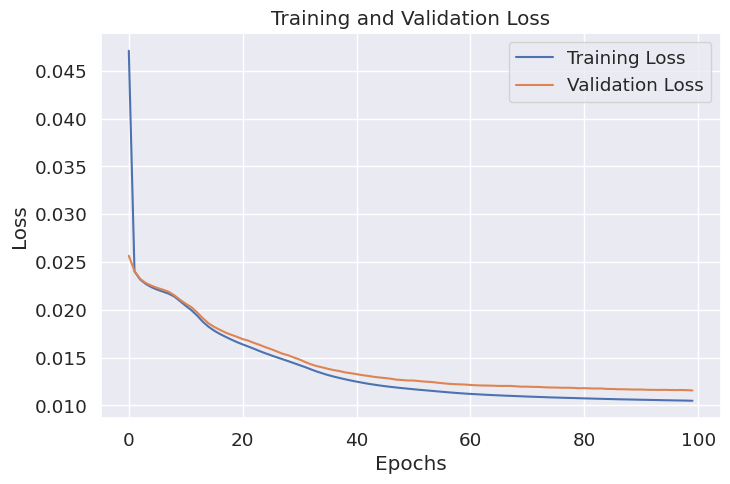

In [16]:
# Plot the loss graph.
# Extract loss and validation loss from the history object
train_loss = history_1dcnn.history['loss']
val_loss = history_1dcnn.history['val_loss']

# Generate a range for the number of epochs
epochs = range(len(train_loss))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Saving the figure
save_path = '../figures/losses_1DCNN.pdf'
plt.savefig(save_path)
plt.show()

In [57]:
test_loss_1d_cnn, test_rmse_1d_cnn = cnn_model.evaluate(w_1dcnn.test, verbose=2)
print(f"Test Loss: {test_loss_1d_cnn}, Test RMSE: {test_rmse_1d_cnn}")

209/209 - 6s - loss: 0.0117 - root_mean_squared_error: 0.1082 - 6s/epoch - 31ms/step
Test Loss: 0.011705913580954075, Test RMSE: 0.10819385945796967


In [59]:
# Assuming each batch in w_1dcnn.anol (except possibly the last) contains 1024 samples
num_batches = len(w_1dcnn.anol)

# Measure inference time
start_time = time.time()
# Predict anomalous samples
anomalous_predictions = cnn_model.predict(w_1dcnn.anol, batch_size=1024)
end_time = time.time()

# Calculate total and average inference time
total_inference_time = end_time - start_time
total_samples = num_batches * 1024  # Assuming each batch has 1024 samples
average_inference_time_per_sample = total_inference_time / total_samples

print(f"Total inference time for all samples: {total_inference_time} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample} seconds")

Total inference time for all samples: 25.272363662719727 seconds
Average inference time per sample: 3.697103117730322e-05 seconds
662/662 [==============================] - 20s 30ms/step


In [60]:
# Reshape predictions to 2D so we can scale back.
reshaped_predictions = anomalous_predictions.reshape(-1, 9)

# Inverse transform to original scale
# Assuming scaler_X is your StandardScaler instance
anol_preds = scaler_X.inverse_transform(reshaped_predictions)

# Drop the first 755 rows from nicla_anol to match the shape with anol_preds
adjusted_nicla_anol = nicla_anol[755:]

# Assuming anol_preds and reshaped_predictions are numpy arrays
rmse_per_row = np.sqrt(np.mean(np.square(anol_preds - adjusted_nicla_anol), axis=1))

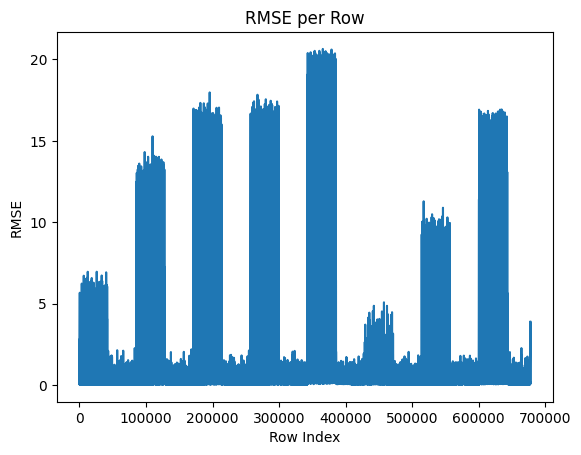

In [61]:
plt.plot(rmse_per_row)
plt.xlabel('Row Index')
plt.ylabel('RMSE')
plt.title('RMSE per Row')
plt.savefig('../figures/rmse_sliding_windows_1d_cnn.pdf', format='pdf')
plt.show()

**Due to presence of idle points we will convert these into sample windows based on periodicity.**

In [62]:
window_size = 755
rmse_sliding_sums = np.convolve(rmse_per_row, np.ones(window_size), 'valid')

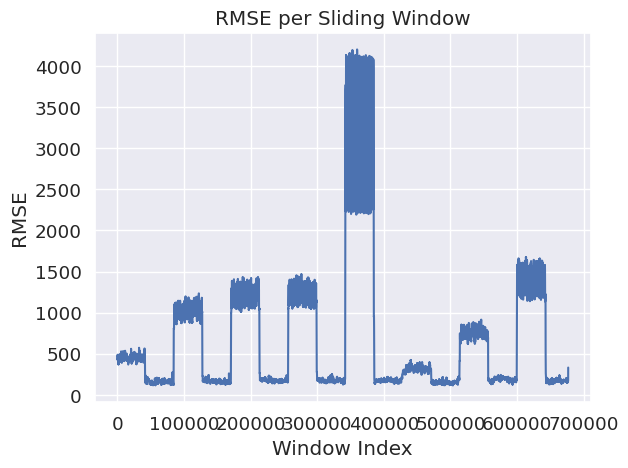

In [63]:
plt.plot(rmse_sliding_sums)
plt.xlabel('Window Index')
plt.ylabel('RMSE')
plt.title('RMSE per Sliding Window')
plt.savefig('../figures/rmse_final_sliding_windows_1d_cnn.pdf', format='pdf')
plt.show()

**Prepare labels in a way that it matches with sliding sum rmse windows.**

In [64]:
# Flatten array to 1D.
adjusted_labels = nicla_labels_anol[755:].ravel()  
binary_result = np.convolve(adjusted_labels, np.ones(window_size), 'valid') > (755 / 2)
binary_result = binary_result.astype(int)
print(f"The length of the labels: {len(binary_result)}")
print(f"The length of the windows: {len(rmse_sliding_sums)}")

The length of the labels: 676807
The length of the windows: 676807


**We do a fine tuning now, as we can estimate the best threshold.**

In [66]:
# Limits to find the threshold
min_rmse = np.min(rmse_sliding_sums)
max_rmse = np.max(rmse_sliding_sums)

# Initialize variables for the best metrics
best_metrics = {'F1': 0}
best_predictions = None

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
    predictions = (rmse_sliding_sums > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }
        best_predictions = predictions

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

Best Threshold: 251.2974981731094
Best F1 Score: 0.992541656724149
Precision: 0.9867014198266585
Recall: 0.9984514414182337
Accuracy: 0.9924262012656488
FPR: 0.013714241390934937


In [27]:
# Compute confusion matrix at the best threshold
# For plotting purposes only
cm = confusion_matrix(binary_result, best_predictions)

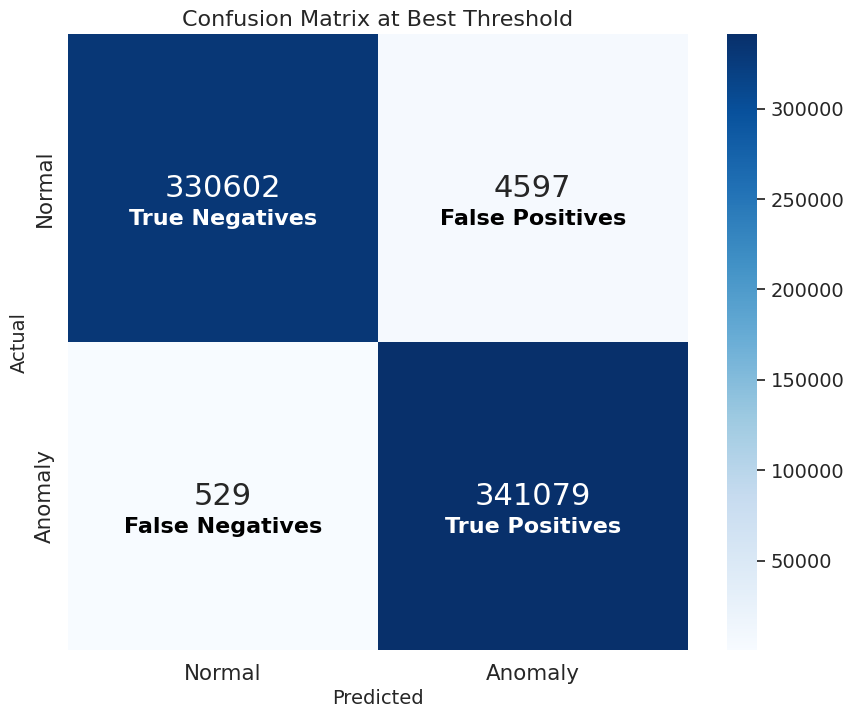

In [46]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)  # Increase font scale for better readability
ax = sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                 xticklabels=['Normal', 'Anomaly'],
                 yticklabels=['Normal', 'Anomaly'],
                 annot_kws={"size": 22})  # Increase font size for annotations

# Title and labels
plt.title('Confusion Matrix at Best Threshold', fontsize=16)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)

# Annotations with text labels
text_labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
label_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
colors = ["white", "black", "black", "white"]
for pos, text_label, color in zip(label_positions, text_labels, colors):
    ax.text(pos[1] + 0.5, pos[0] + 0.6, text_label,
            ha="center", va="center", color=color, fontsize=16, weight='bold')  # Adjust font size if necessary

# Increase color bar label size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Adjust to desired size

# Save the figure
plt.savefig('../figures/1d_cnn_cm_corrected.pdf', format='pdf')
plt.show()

## LSTM

In [127]:
patience = 3
batch_size = 1024
sequence_stride = 1

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  # optimizer=tf.keras.optimizers.RMSprop(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def anol(self):
    return self.make_dataset(self.anol_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, anol_df, label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.anol_df = anol_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.anol = anol
WindowGenerator.example = example

In [3]:
%%time
# Load the arrays
nicla_nor = np.load('../outputs/nicla_nor.npy')
nicla_anol = np.load('../outputs/nicla_anol.npy')
nicla_labels_anol = np.load('../outputs/nicla_labels_anol.npy')

# Calculate the indices for the split
total_length = len(nicla_nor)
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the data
train_data = nicla_nor[:train_end]
validation_data = nicla_nor[train_end:val_end]
test_data = nicla_nor[val_end:]

# Scaling
scaler_X = StandardScaler().fit(train_data)
X_train, X_val, X_test, X_anol = [pd.DataFrame(scaler_X.transform(data), 
                                  columns=["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagX", "MagY", "MagZ"]) 
                                  for data in [train_data, validation_data, test_data, nicla_anol]]

MAX_EPOCHS = 100 # Can increase more for further analysis.
NUM_FILTERS = 8
NUM_FEATURES = 9
WINDOW_SIZE = 755 # This is output size.
OUT_SIZE = 1 # Gives the best result.

# # LSTM model
# lstm_model = Sequential([
#     LSTM(NUM_FILTERS, return_sequences=False, input_shape=(755, 9), 
#                          kernel_regularizer=l1(0.001)),
#     #Dense(NUM_FILTERS, activation='relu'),
#     #Dropout(0.2),
#     Dense(NUM_FEATURES),
#     Reshape([1, NUM_FEATURES], input_shape=(NUM_FEATURES,))
# ])

# Adjusted LSTM model with Batch Normalization
lstm_model = Sequential([
    LSTM(NUM_FILTERS, return_sequences=True, input_shape=(755, 9)),
    BatchNormalization(),
    Dropout(0.1),
    LSTM(NUM_FILTERS, return_sequences=False),
    BatchNormalization(),
    Dense(NUM_FILTERS, activation='tanh'),
    # Dropout(0.1),
    Dense(NUM_FEATURES),
    Reshape([1, NUM_FEATURES])
])

val_performance = {}
loss = {}
val_loss = {}

lstm_model.build(input_shape=(None, 755, 9))
lstm_model.summary()

# Set window.
w_lstm = WindowGenerator(input_width=WINDOW_SIZE, label_width=OUT_SIZE, shift=OUT_SIZE,
                     train_df=X_train, val_df=X_val, test_df = X_test, anol_df = X_anol)

# Verify the model input/output shape.
print('Input shape:', w_lstm.example[0].shape)
print('Output shape:', lstm_model(w_lstm.example[0]).shape)

2023-12-07 10:55:33.449709: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46646 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 755, 8)            576       
                                                                 
 batch_normalization_12 (Ba  (None, 755, 8)            32        
 tchNormalization)                                               
                                                                 
 dropout_14 (Dropout)        (None, 755, 8)            0         
                                                                 
 lstm_23 (LSTM)              (None, 8)                 544       
                                                                 
 batch_normalization_13 (Ba  (None, 8)                 32        
 tchNormalization)                                               
                                                                 
 dense_21 (Dense)            (None, 8)               

2023-12-07 10:55:35.021009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


Output shape: (1024, 1, 9)
CPU times: user 1.95 s, sys: 1.14 s, total: 3.09 s
Wall time: 2.41 s
Input shape: (1024, 755, 9)
Output shape: (1024, 1, 9)
CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 923 ms


In [180]:
# Train the model.
# Compile and evaluate.
history_lstm = compile_and_fit(lstm_model, w_lstm)

Epoch 1/100
628/628 [==============================] - 65s 98ms/step - loss: 0.7021 - root_mean_squared_error: 0.7692 - val_loss: 0.4199 - val_root_mean_squared_error: 0.5653
Epoch 2/100
628/628 [==============================] - 61s 98ms/step - loss: 0.3178 - root_mean_squared_error: 0.4784 - val_loss: 0.2089 - val_root_mean_squared_error: 0.3626
Epoch 3/100
628/628 [==============================] - 61s 98ms/step - loss: 0.1740 - root_mean_squared_error: 0.3261 - val_loss: 0.1184 - val_root_mean_squared_error: 0.2446
Epoch 4/100
628/628 [==============================] - 61s 98ms/step - loss: 0.1131 - root_mean_squared_error: 0.2494 - val_loss: 0.0811 - val_root_mean_squared_error: 0.1924
Epoch 5/100
628/628 [==============================] - 61s 98ms/step - loss: 0.0870 - root_mean_squared_error: 0.2187 - val_loss: 0.0646 - val_root_mean_squared_error: 0.1722
Epoch 6/100
628/628 [==============================] - 61s 98ms/step - loss: 0.0735 - root_mean_squared_error: 0.2039 - val_l

Save or load the model based on your needs.

In [191]:
# Save the model.
# lstm_model.save("../models/LSTM" + ".keras")

# Load the model
lstm_model = load_model("../models/LSTM" + ".keras")

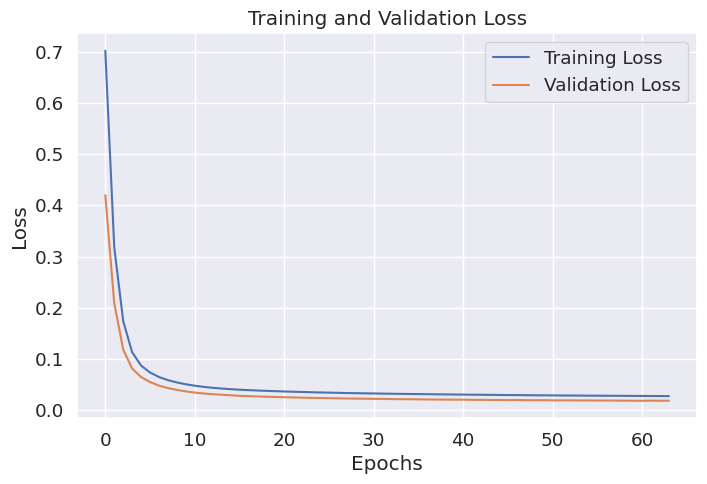

In [192]:
# Plot the loss graph.
# Extract loss and validation loss from the history object
train_loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

# Generate a range for the number of epochs
epochs = range(len(train_loss))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Saving the figure
# save_path = '../figures/losses_lstm.pdf'
# plt.savefig(save_path)
plt.show()

In [193]:
test_loss_lstm, test_rmse_lstm = lstm_model.evaluate(w_lstm.test, verbose=2)
print(f"Test Loss: {test_loss_lstm}, Test RMSE: {test_rmse_lstm}")

209/209 - 11s - loss: 0.0119 - root_mean_squared_error: 0.1091 - 11s/epoch - 51ms/step
Test Loss: 0.011897680349647999, Test RMSE: 0.10907646268606186


We check the inference time.

In [194]:
# Measure inference time
start_time = time.time()
# Predict anomalous samples
anomalous_predictions = lstm_model.predict(w_lstm.anol)
end_time = time.time()

# Calculate the total inference time
total_inference_time = end_time - start_time

# Number of samples that were actually predicted
# We cannot predict the first 755 = window size
num_predicted_samples = len(nicla_anol) - 755

# Calculate the average inference time per sample
average_inference_time_per_sample = total_inference_time / num_predicted_samples

print(f"Total inference time for all samples: {total_inference_time} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample} seconds")

662/662 [==============================] - 35s 51ms/step
Total inference time for all samples: 35.100478649139404 seconds
Average inference time per sample: 5.180416028835692e-05 seconds


In [195]:
len(w_lstm.anol), len(nicla_anol)

(662, 678316)

We do the below one for fair comparison.

In [196]:
# Reshape predictions to 2D so we can scale back.
reshaped_predictions = anomalous_predictions.reshape(-1, 9)

# Inverse transform to original scale
# Assuming scaler_X is your StandardScaler instance
anol_preds = scaler_X.inverse_transform(reshaped_predictions)

# Drop the first 755 rows from nicla_anol to match the shape with anol_preds
adjusted_nicla_anol = nicla_anol[755:]

# Assuming anol_preds and reshaped_predictions are numpy arrays
rmse_per_row = np.sqrt(np.mean(np.square(anol_preds - adjusted_nicla_anol), axis=1))

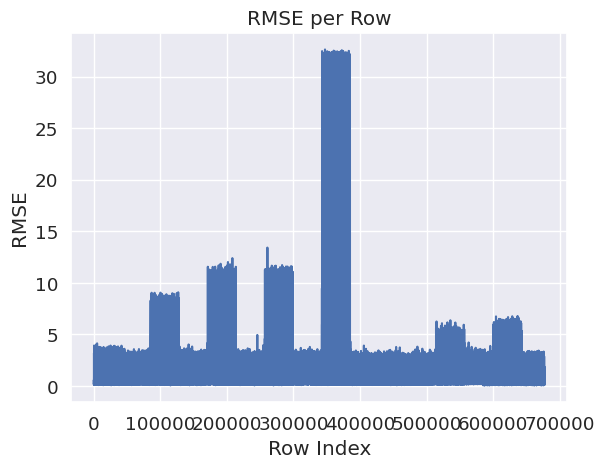

In [197]:
plt.plot(rmse_per_row)
plt.xlabel('Row Index')
plt.ylabel('RMSE')
plt.title('RMSE per Row')
plt.savefig('../figures/rmse_sliding_windows_lstm.pdf', format='pdf')
plt.show()

In [198]:
window_size = 755
rmse_sliding_sums = np.convolve(rmse_per_row, np.ones(window_size), 'valid')

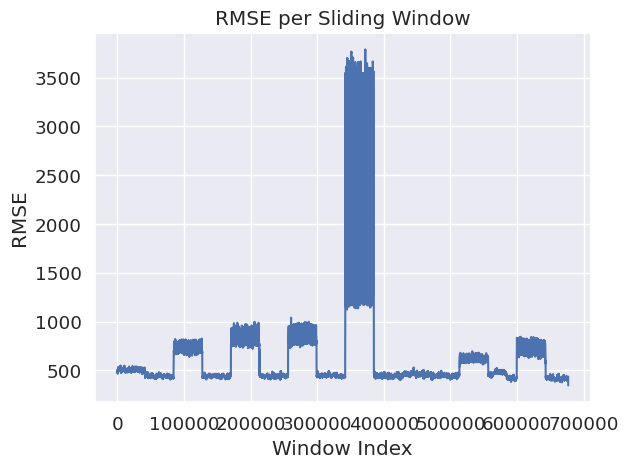

In [199]:
plt.plot(rmse_sliding_sums)
plt.xlabel('Window Index')
plt.ylabel('RMSE')
plt.title('RMSE per Sliding Window')
plt.savefig('../figures/rmse_final_sliding_windows_lstm.pdf', format='pdf')
plt.show()

We see that LSTM fails to idenfity 5% decrease anomalies.

In [200]:
# Flatten array to 1D and create binary result
adjusted_labels = nicla_labels_anol[755:].ravel()  
binary_result = np.convolve(adjusted_labels, np.ones(window_size), 'valid') > (755 / 2)
binary_result = binary_result.astype(int)

print(f"The length of the labels: {len(binary_result)}")
print(f"The length of the windows: {len(rmse_sliding_sums)}")

# Limits to find the threshold
min_rmse = np.min(rmse_sliding_sums)
max_rmse = np.max(rmse_sliding_sums)

# Initialize variables for the best metrics
best_metrics = {'Threshold': None, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'FPR': 0}

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
    predictions = (rmse_sliding_sums > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

The length of the labels: 676807
The length of the windows: 676807
Best Threshold: 478.41436992398707
Best F1 Score: 0.920916475193022
Precision: 0.9514519466979645
Recall: 0.8922800402800871
Accuracy: 0.9226500316929346
FPR: 0.04639930310054624


## Dense-AE

In [31]:
# Load the arrays: normal, and anomalous data, and labels.
nicla_nor = np.load('../outputs/nicla_nor.npy')
nicla_anol = np.load('../outputs/nicla_anol.npy')
nicla_labels_anol = np.load('../outputs/nicla_labels_anol.npy')

# Calculate the indices for the split
total_length = nicla_nor.shape[0]
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the data
train_data = nicla_nor[:train_end]
validation_data = nicla_nor[train_end:val_end]
test_data = nicla_nor[val_end:]

# Scaling
scaler_X = StandardScaler().fit(train_data)
X_train = scaler_X.transform(train_data)
X_val = scaler_X.transform(validation_data)
X_test = scaler_X.transform(test_data)
X_anol = scaler_X.transform(nicla_anol)

In [32]:
# Care for the dropout rate.
@tf.keras.utils.register_keras_serializable()
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        # Encoder
        self.encoder = Sequential([
            Flatten(),  # Flatten the input
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(16, activation="relu"),
        ])
        # Decoder
        self.decoder = Sequential([
            Dense(16, activation="relu"),
            Dense(32, activation="relu"),
            Dense(64, activation="relu"),
            Dense(755 * 9, activation="relu"),
            Reshape((755, 9))  # Reshape back to the original shape
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def create_windows(data, window_size=755, sliding_number=1):
    num_windows = (data.shape[0] - window_size) // sliding_number + 1
    shape = (num_windows, window_size, data.shape[-1])
    strides = (data.strides[0] * sliding_number, data.strides[0], data.strides[1])
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

# Set input and target data using the updated window creation function
X_train_windows = create_windows(X_train)
X_train_target = create_windows(train_data)
X_val_windows = create_windows(X_val)
X_val_target = create_windows(validation_data)
X_test_windows = create_windows(X_test)
X_test_target = create_windows(test_data)
X_anol_windows = create_windows(X_anol)
nicla_anol_windows = create_windows(nicla_anol)

# Initialize and compile the model with a lower learning rate
ae_dense = AnomalyDetector()
ae_dense.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mse')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

2023-12-07 11:06:49.392036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46646 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [4]:
# Check if the function is working as expected
first_window_second_timestep = X_train_windows[0][1]  # Second timestep of the first window
second_window_first_timestep = X_train_windows[1][0]  # First timestep of the second window

# Compare these two timesteps
comparison_result = np.array_equal(first_window_second_timestep, second_window_first_timestep)

print("Is the create_windows function working correctly?", comparison_result)

Is the create_windows function working correctly? True


In [5]:
# Model training with batch processing
history_dense_ae = ae_dense.fit(
    X_train_windows,
    X_train_target,  # Targets for training data
    epochs=100,
    batch_size=512,  # Adjust batch size as needed
    validation_data=(X_val_windows, X_val_target),
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1
)

Epoch 1/100


2023-11-23 20:05:39.548594: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa824d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 20:05:39.548653: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-23 20:05:39.556890: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-23 20:05:39.582446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-23 20:05:39.743373: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1256/1256 [==============================] - 38s 28ms/step - loss: 156.9074 - val_loss: 141.1836
Epoch 2/100
1256/1256 [==============================] - 20s 16ms/step - loss: 140.5716 - val_loss: 139.8239
Epoch 3/100
1256/1256 [==============================] - 21s 16ms/step - loss: 139.6260 - val_loss: 139.0892
Epoch 4/100
1256/1256 [==============================] - 20s 16ms/step - loss: 139.1741 - val_loss: 138.8561
Epoch 5/100
1256/1256 [==============================] - 20s 16ms/step - loss: 139.0057 - val_loss: 138.7723
Epoch 6/100
1256/1256 [==============================] - 20s 16ms/step - loss: 138.9204 - val_loss: 138.7045
Epoch 7/100
1256/1256 [==============================] - 20s 16ms/step - loss: 138.8818 - val_loss: 138.5232
Epoch 8/100
1256/1256 [==============================] - 20s 16ms/step - loss: 138.6622 - val_loss: 138.4559
Epoch 9/100
1256/1256 [==============================] - 20s 16ms/step - loss: 138.6208 - val_loss: 138.4165
Epoch 10/100
1256/1256 [=======

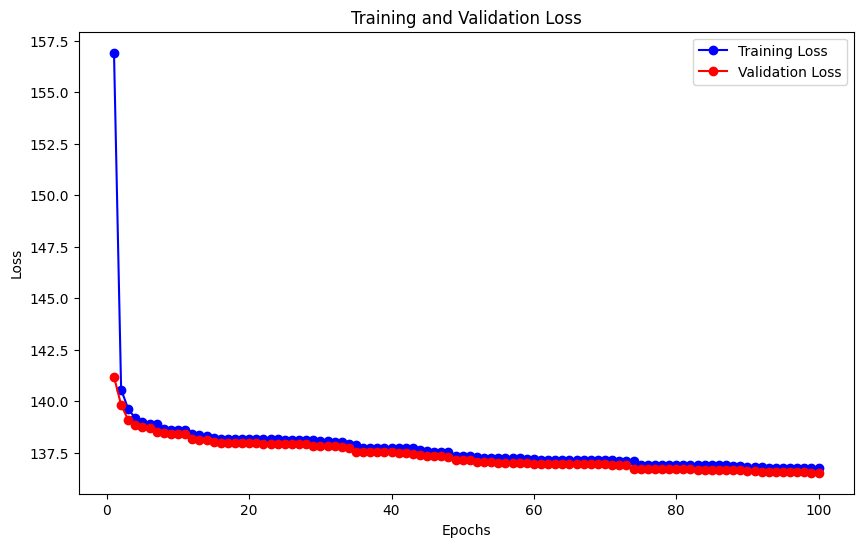

In [6]:
### Extracting loss and validation loss
train_loss_ae_dense = history_dense_ae.history['loss']
val_loss_ae_dense = history_dense_ae.history['val_loss']
epochs = range(1, len(train_loss_ae_dense) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_ae_dense, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_ae_dense, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
# Save our model just in case.
# ae_dense.save('../models/AE_dense.keras')

# Load from here if kernel died previously
ae_dense = tf.keras.models.load_model('../models/AE_dense.keras', custom_objects={'AnomalyDetector': AnomalyDetector})

In [5]:
# Get the test loss.
rmse_ae_dense = np.sqrt(ae_dense.evaluate(X_test_windows, X_test_windows, batch_size=1024))
print("Test Loss (RMSE):", rmse_ae_dense)

209/209 [==============================] - 4s 15ms/step - loss: 183.7122
Test Loss (RMSE): 13.554048075696103


In [14]:
def predict_in_chunks(model, data, batch_size):
    reconstructed = []
    inference_times = []
    for i in range(0, len(data), batch_size):
        chunk = data[i:i + batch_size]
        start_time = time.time()  # Start time for the chunk prediction
        reconstructed_chunk = model.predict(chunk, batch_size=batch_size, verbose=0)
        end_time = time.time()  # End time for the chunk prediction
        inference_time = (end_time - start_time) / len(chunk)  # Inference time per sample
        inference_times.append(inference_time)  # Collect per sample inference time for each chunk
        reconstructed.append(reconstructed_chunk)
    average_inference_time_per_sample = np.mean(inference_times)  # Average over all chunks
    return np.concatenate(reconstructed, axis=0), average_inference_time_per_sample

# Use the function to predict and get average inference time per sample
nicla_anol_reconstructed, avg_inf_time_per_sample = predict_in_chunks(ae_dense, X_anol_windows, batch_size=1024)

# Save the nicla_anol_reconstructed array to a file
np.save('../outputs/nicla_anol_reconstructed.npy', nicla_anol_reconstructed)

print(f"Average inference time per sample: {avg_inf_time_per_sample} seconds")

Average inference time per sample: 0.00010396785088186119 seconds


We do this one for fair comparison. Machine collapses so we do half and double it.

In [34]:
# Select half of the samples from the dataset
half_data = X_anol_windows[:len(X_anol_windows) // 2]

# Measure inference time for AE model on half of the samples
start_time = time.time()
# Predict half of the samples
ae_reconstructed_half = ae_dense.predict(half_data)
end_time = time.time()

# Calculate the total inference time
total_inference_time = end_time - start_time

# Calculate the average inference time per sample
average_inference_time_per_sample = total_inference_time / len(half_data)

print(f"Total inference time for half of the AE samples: {total_inference_time} seconds")
print(f"Average inference time per AE sample (half dataset): {average_inference_time_per_sample} seconds")

# Optional: Save the ae_reconstructed_half array to a file
np.save('../outputs/ae_reconstructed_half.npy', ae_reconstructed_half)

10587/10587 [==============================] - 39s 4ms/step
Total inference time for half of the AE samples: 64.93970704078674 seconds
Average inference time per AE sample (half dataset): 0.00019168639044334464 seconds


In [7]:
nicla_anol_reconstructed.shape, nicla_anol_windows.shape, nicla_labels_anol.shape

((677562, 755, 9), (677562, 755, 9), (678316, 1))

In [8]:
# Calculate MSE for each window
mse_per_window = np.mean((nicla_anol_windows - nicla_anol_reconstructed) ** 2, axis=(1, 2))

# Calculate RMSE for each window
rmse_per_window = np.sqrt(mse_per_window)

# Check the length of the RMSE array to ensure it's 677562
print("Length of RMSE array:", len(rmse_per_window))

Length of RMSE array: 677562


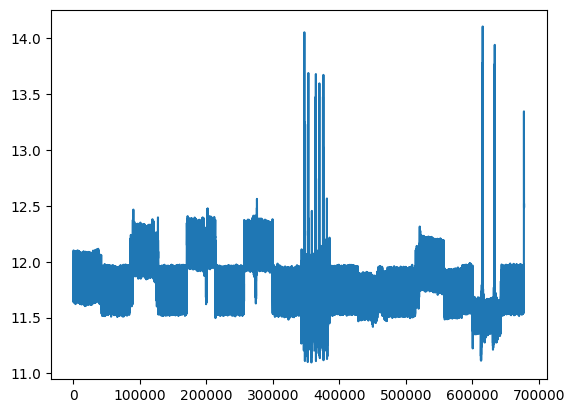

In [9]:
plt.plot(rmse_per_window)
plt.show()

In [11]:
# Get labels for windows.
window_size = 755
threshold = window_size / 2
binary_result = np.convolve(nicla_labels_anol.ravel(), np.ones(window_size, dtype=int), 'valid') > threshold
# Convert boolean array to integers (1s and 0s)
binary_result = binary_result.astype(int)

In [13]:
# # Initialize best metrics
# best_metrics = {'Threshold': 0, 'F1': 0, 'Recall': 0, 'Precision': 0, 'Accuracy': 0, 'FPR': 0}

# # Setting search parameters
# num_points = 300  # Total number of points for granularity
# search_range = 10  # Range for searching around the initial best threshold

# # Calculate the bounds for the search
# lower_bound = rmse_per_window.min()
# upper_bound = rmse_per_window.max() + search_range / 2

# # Searching for the best threshold
# for threshold in np.linspace(lower_bound, upper_bound, num=num_points):
#     labeled_windows = (rmse_per_window > threshold).astype(int)
#     f1 = f1_score(binary_result, labeled_windows)

#     if f1 > best_metrics['F1']:
#         tn, fp, fn, tp = confusion_matrix(binary_result, labeled_windows).ravel()
#         best_metrics = {
#             'Threshold': threshold,
#             'F1': f1,
#             'Recall': recall_score(binary_result, labeled_windows),
#             'Precision': precision_score(binary_result, labeled_windows),
#             'Accuracy': accuracy_score(binary_result, labeled_windows),
#             'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
#         }

# # Printing the best metrics
# print(f"Best Threshold: {best_metrics['Threshold']}")
# print(f"Best F1 Score: {best_metrics['F1']}")
# print(f"Recall: {best_metrics['Recall']}")
# print(f"Precision: {best_metrics['Precision']}")
# print(f"Accuracy: {best_metrics['Accuracy']}")
# print(f"FPR: {best_metrics['FPR']}")

# Limits to find the threshold
min_rmse = np.min(rmse_per_window)
max_rmse = np.max(rmse_per_window)

# Initialize variables for the best metrics
best_metrics = {'Threshold': None, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'FPR': 0}

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
    predictions = (rmse_per_window > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

Best Threshold: 11.805595950819834
Best F1 Score: 0.6974921622994796
Precision: 0.8782334835526878
Recall: 0.5783073056960011
Accuracy: 0.7464995610733778
FPR: 0.0818349311901288


## LSTM-AE

In [2]:
# Load the arrays: normal, and anomalous data, and labels.
nicla_nor = np.load('../outputs/nicla_nor.npy')
nicla_anol = np.load('../outputs/nicla_anol.npy')
nicla_labels_anol = np.load('../outputs/nicla_labels_anol.npy')

# Calculate the indices for the split
total_length = nicla_nor.shape[0]
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the data
train_data = nicla_nor[:train_end]
validation_data = nicla_nor[train_end:val_end]
test_data = nicla_nor[val_end:]

# Scaling
scaler_X = StandardScaler().fit(train_data)
X_train = scaler_X.transform(train_data)
X_val = scaler_X.transform(validation_data)
X_test = scaler_X.transform(test_data)
X_anol = scaler_X.transform(nicla_anol)

In [3]:
@tf.keras.utils.register_keras_serializable()
class LSTMAutoencoder(Model):
    def __init__(self, timesteps, num_features):
        super(LSTMAutoencoder, self).__init__()
        self.timesteps = timesteps
        self.num_features = num_features

        # Encoder with reduced complexity and added dropout
        self.encoder = Sequential([
            LSTM(16, activation='tanh', input_shape=(timesteps, num_features), dropout=0.2)
        ])

        # Decoder with reduced complexity and added dropout
        self.decoder = Sequential([
            RepeatVector(timesteps),
            LSTM(16, activation='tanh', return_sequences=True, dropout=0.2),
            Flatten(),  # Flatten the output
            Dense(timesteps * num_features),  # Dense layer to reshape the output
            Reshape((timesteps, num_features))  # Reshape back to the original shape
        ])

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
def create_windows(data, window_size=755, sliding_number=1):
    num_windows = (data.shape[0] - window_size) // sliding_number + 1
    shape = (num_windows, window_size, data.shape[-1])
    strides = (data.strides[0] * sliding_number, data.strides[0], data.strides[1])
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

# Set input and target data using the updated window creation function
X_train_windows = create_windows(X_train)
X_train_target = create_windows(train_data)
X_val_windows = create_windows(X_val)
X_val_target = create_windows(validation_data)
X_test_windows = create_windows(X_test)
X_test_target = create_windows(test_data)
X_anol_windows = create_windows(X_anol)
nicla_anol_windows = create_windows(nicla_anol)
window_size = 755
num_features = 9

# Initialize and compile the LSTM autoencoder
lstm_autoencoder = LSTMAutoencoder(window_size, num_features)

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# lstm_autoencoder.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
lstm_autoencoder.compile(optimizer=RMSprop(learning_rate=0.002), loss='mse')

2023-12-02 19:20:17.893906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46646 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [5]:
# Train the model and save the history
history_lstm = lstm_autoencoder.fit(
    X_train_windows,
    X_train_target,
    epochs=100,
    batch_size=1024,
    validation_data=(X_val_windows, X_val_target),
    callbacks=[early_stopping, reduce_lr],
    shuffle=False,
    verbose=1
)

Epoch 1/100


2023-11-23 22:16:20.914976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-23 22:16:21.508131: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f90ac005820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 22:16:21.508172: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-23 22:16:21.514895: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-23 22:16:21.627077: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


628/628 [==============================] - 99s 150ms/step - loss: 56.1616 - val_loss: 27.8605 - lr: 0.0020
Epoch 2/100
628/628 [==============================] - 79s 126ms/step - loss: 26.7921 - val_loss: 21.1875 - lr: 0.0020
Epoch 3/100
628/628 [==============================] - 79s 126ms/step - loss: 20.0180 - val_loss: 16.5581 - lr: 0.0020
Epoch 4/100
628/628 [==============================] - 79s 126ms/step - loss: 16.6374 - val_loss: 13.7797 - lr: 0.0020
Epoch 5/100
628/628 [==============================] - 79s 126ms/step - loss: 12.9800 - val_loss: 9.3571 - lr: 0.0020
Epoch 6/100
628/628 [==============================] - 79s 126ms/step - loss: 10.4154 - val_loss: 12.8306 - lr: 0.0020
Epoch 7/100
628/628 [==============================] - 79s 126ms/step - loss: 8.8059 - val_loss: 10.9851 - lr: 0.0020
Epoch 8/100
628/628 [==============================] - 79s 126ms/step - loss: 7.6275 - val_loss: 9.4862 - lr: 0.0020
Epoch 9/100
628/628 [==============================] - 79s 126ms

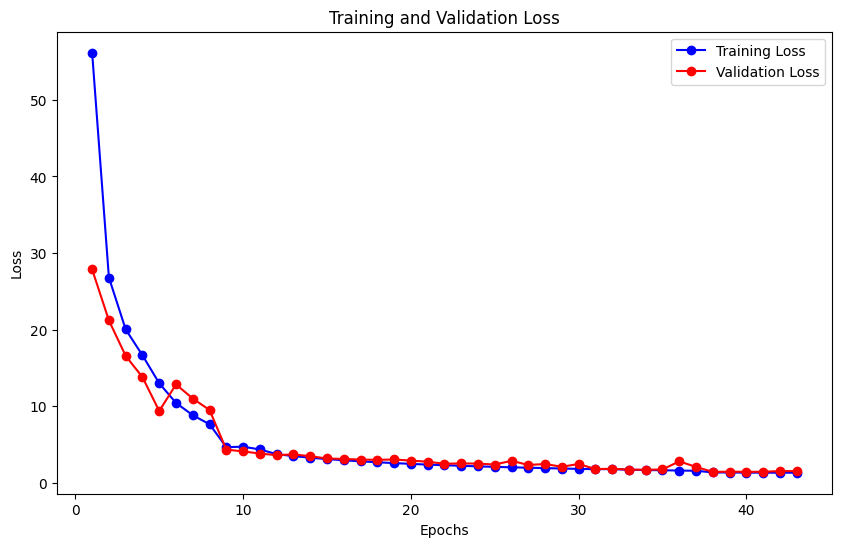

In [6]:
### Extracting loss and validation loss
train_loss_lstm_ae = history_lstm.history['loss']
val_loss_lstm_ae = history_lstm.history['val_loss']
epochs = range(1, len(train_loss_lstm_ae) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_lstm_ae, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_lstm_ae, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/rmse_final_sliding_windows_lstm_dropout_02_rmsProp.pdf', format='pdf')
plt.show()

**We can save/load model when below. Comment accordingly.**

In [4]:
# Save the trained LSTM autoencoder model
# lstm_autoencoder.save('../models/lstm_ae_layers_dropout_02_rmsProp.keras')
# Load the trained LSTM autoencoder model
# Load the model with a custom object scope
with tf.keras.utils.custom_object_scope({'LSTMAutoencoder': LSTMAutoencoder}):
    lstm_autoencoder = tf.keras.models.load_model('../models/lstm_ae_layers_dropout_02_rmsProp.keras')

In [7]:
# Calculate the test loss using prepared test data with specified batch size
test_loss = lstm_autoencoder.evaluate(X_test_windows, X_test_target, batch_size=512, verbose=1)
print(f"Test Loss: {test_loss}")

2023-11-24 07:10:15.794544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


418/418 [==============================] - 21s 46ms/step - loss: 1.4002
Test Loss: 1.4002264738082886


**We prepare anomalous data.**

In [5]:
def predict_in_chunks(model, data, batch_size):
    reconstructed = []
    inference_times = []
    for i in range(0, len(data), batch_size):
        chunk = data[i:i + batch_size]
        start_time = time.time()  # Start time for the chunk prediction
        reconstructed_chunk = model.predict(chunk, batch_size=batch_size, verbose=0)
        end_time = time.time()  # End time for the chunk prediction
        inference_time = (end_time - start_time) / len(chunk)  # Inference time per sample
        inference_times.append(inference_time)  # Collect per sample inference time for each chunk
        reconstructed.append(reconstructed_chunk)
    average_inference_time_per_sample = np.mean(inference_times)  # Average over all chunks
    return np.concatenate(reconstructed, axis=0), average_inference_time_per_sample

# Use the function to predict and get average inference time per sample
nicla_anol_reconstructed, avg_inf_time_per_sample = predict_in_chunks(lstm_autoencoder, X_anol_windows, batch_size=1024)

# Save the nicla_anol_reconstructed array to a file
np.save('../outputs/nicla_anol_reconstructed_lstm.npy', nicla_anol_reconstructed)

print(f"Average inference time per sample: {avg_inf_time_per_sample} seconds")

Average inference time per sample: 0.00014221380802904347 seconds


In [5]:
# Select half of the samples from the dataset
half_data = X_anol_windows[:len(X_anol_windows) // 2]

# Measure inference time for AE model on half of the samples
start_time = time.time()
# Predict half of the samples
ae_lstm_reconstructed_half = lstm_autoencoder.predict(half_data)
end_time = time.time()

# Calculate the total inference time
total_inference_time = end_time - start_time

# Calculate the average inference time per sample
average_inference_time_per_sample = total_inference_time / len(half_data)

print(f"Total inference time for half of the AE samples: {total_inference_time} seconds")
print(f"Average inference time per AE sample (half dataset): {average_inference_time_per_sample} seconds")

# Optional: Save the ae_reconstructed_half array to a file
np.save('../outputs/ae_lstm_autoencoder_reconstructed_half.npy', ae_lstm_reconstructed_half)

2023-12-02 19:21:31.474960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


10587/10587 [==============================] - 322s 30ms/step
Total inference time for half of the AE samples: 345.17320108413696 seconds
Average inference time per AE sample (half dataset): 0.001031368239612425 seconds


In [13]:
# Calculate MSE for each window
mse_per_window = np.mean((nicla_anol_windows - nicla_anol_reconstructed) ** 2, axis=(1, 2))

# Calculate RMSE for each window
rmse_per_window = np.sqrt(mse_per_window)

# Check the length of the RMSE array to ensure it's 677562
print("Length of RMSE array:", len(rmse_per_window))

Length of RMSE array: 677562


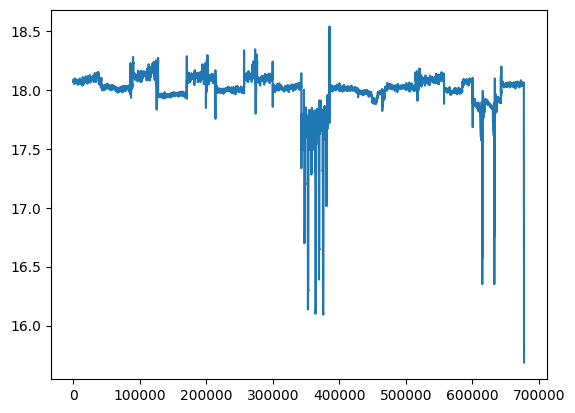

In [15]:
plt.plot(rmse_per_window)
plt.show()

In [16]:
# Get labels for windows.
window_size = 755
threshold = window_size / 2
binary_result = np.convolve(nicla_labels_anol.ravel(), np.ones(window_size, dtype=int), 'valid') > threshold
# Convert boolean array to integers (1s and 0s)
binary_result = binary_result.astype(int)

In [18]:
# Limits to find the threshold
min_rmse = np.min(rmse_per_window)
max_rmse = np.max(rmse_per_window)

# Initialize variables for the best metrics
best_metrics = {'Threshold': None, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'FPR': 0}

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
    predictions = (rmse_per_window > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

Best Threshold: 1.825342174048758
Best F1 Score: 0.9112386476243395
Precision: 0.9272587638404276
Recall: 0.8957626846358981
Accuracy: 0.911823567437371
FPR: 0.07177229049012676


## 1D-CNN AE

In [39]:
# Load the arrays: normal, and anomalous data, and labels.
nicla_nor = np.load('../outputs/nicla_nor.npy')
nicla_anol = np.load('../outputs/nicla_anol.npy')
nicla_labels_anol = np.load('../outputs/nicla_labels_anol.npy')

# Calculate the indices for the split
total_length = nicla_nor.shape[0]
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the data
train_data = nicla_nor[:train_end]
validation_data = nicla_nor[train_end:val_end]
test_data = nicla_nor[val_end:]

# Scaling
scaler_X = StandardScaler().fit(train_data)
X_train = scaler_X.transform(train_data)
X_val = scaler_X.transform(validation_data)
X_test = scaler_X.transform(test_data)
X_anol = scaler_X.transform(nicla_anol)

In [3]:
@tf.keras.utils.register_keras_serializable()
class CNNAutoencoder(Model):
    def __init__(self, timesteps, num_features, num_filters, conv_width, max_pool_size):
        super(CNNAutoencoder, self).__init__()
        self.timesteps = timesteps
        self.num_features = num_features

        # Encoder
        self.encoder = Sequential([
            Conv1D(num_filters, activation='relu', kernel_size=(conv_width), input_shape=(timesteps, num_features)),
            MaxPooling1D(pool_size=max_pool_size),
            Conv1D(num_filters, activation='relu', kernel_size=(conv_width))
        ])

        # Decoder
        self.decoder = Sequential([
            Conv1D(num_filters, activation='relu', kernel_size=(conv_width)),
            UpSampling1D(size=max_pool_size),
            Conv1D(num_features, activation='relu', kernel_size=(conv_width)),
            Flatten(),
            Dense(timesteps * num_features),
            Reshape((timesteps, num_features))
        ])

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def create_windows(data, window_size=755, sliding_number=1):
    num_windows = (data.shape[0] - window_size) // sliding_number + 1
    shape = (num_windows, window_size, data.shape[-1])
    strides = (data.strides[0] * sliding_number, data.strides[0], data.strides[1])
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

# Set input and target data using the updated window creation function
X_train_windows = create_windows(X_train)
X_train_target = create_windows(train_data)
X_val_windows = create_windows(X_val)
X_val_target = create_windows(validation_data)
X_test_windows = create_windows(X_test)
X_test_target = create_windows(test_data)
X_anol_windows = create_windows(X_anol)
nicla_anol_windows = create_windows(nicla_anol)
# Set hyperparameters
window_size = 755
num_features = 9
num_filters = 32
conv_width = 5
max_pool_size = 3

# Initialize and compile the LSTM autoencoder
cnn_autoencoder = CNNAutoencoder(window_size, num_features, num_filters, conv_width,
                                 max_pool_size)

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# lstm_autoencoder.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
cnn_autoencoder.compile(optimizer=Adamax(learning_rate=0.001), loss='mse')

2023-12-07 11:48:00.420994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46646 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [12]:
# Train the model and save the history
history_cnn = cnn_autoencoder.fit(
    X_train_windows,
    X_train_target,
    epochs=100,
    batch_size=1024,
    validation_data=(X_val_windows, X_val_target),
    callbacks=[early_stopping, reduce_lr],
    shuffle=False,
    verbose=1
)

Epoch 1/100


2023-11-24 07:38:09.798035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-24 07:38:11.112542: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f768021a8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 07:38:11.112589: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-24 07:38:11.119108: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 07:38:11.237865: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


628/628 [==============================] - 52s 74ms/step - loss: 8.9286 - val_loss: 0.2081 - lr: 0.0010
Epoch 2/100
628/628 [==============================] - 33s 53ms/step - loss: 0.1769 - val_loss: 0.1504 - lr: 0.0010
Epoch 3/100
628/628 [==============================] - 33s 53ms/step - loss: 0.1347 - val_loss: 0.1228 - lr: 0.0010
Epoch 4/100
628/628 [==============================] - 33s 53ms/step - loss: 0.1266 - val_loss: 0.1245 - lr: 0.0010
Epoch 5/100
628/628 [==============================] - 33s 53ms/step - loss: 0.1139 - val_loss: 0.1104 - lr: 0.0010
Epoch 6/100
628/628 [==============================] - 33s 53ms/step - loss: 0.1043 - val_loss: 0.0864 - lr: 0.0010
Epoch 7/100
628/628 [==============================] - 34s 54ms/step - loss: 0.0969 - val_loss: 0.0765 - lr: 0.0010
Epoch 8/100
628/628 [==============================] - 33s 53ms/step - loss: 0.0900 - val_loss: 0.0666 - lr: 0.0010
Epoch 9/100
628/628 [==============================] - 34s 53ms/step - loss: 0.0838 

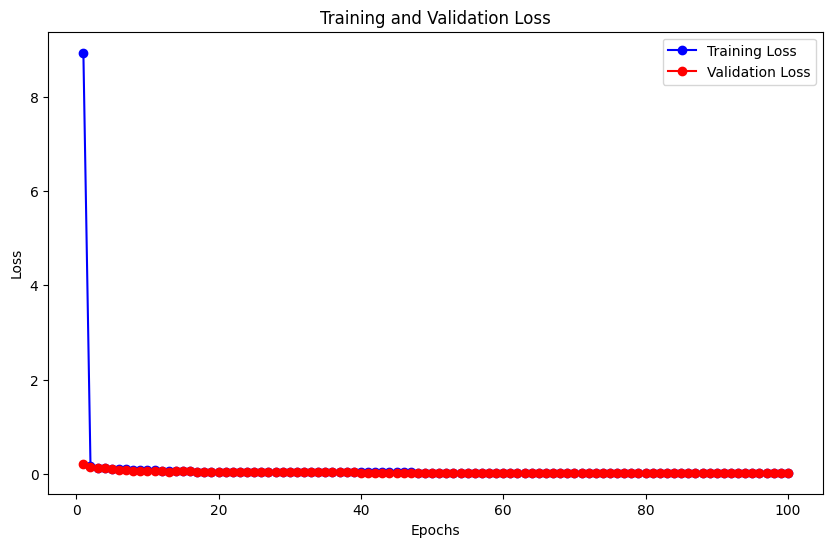

In [14]:
### Extracting loss and validation loss
train_loss_cnn_ae = history_cnn.history['loss']
val_loss_cnn_ae = history_cnn.history['val_loss']
epochs = range(1, len(train_loss_cnn_ae) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_cnn_ae, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_cnn_ae, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/rmse_final_sliding_windows_cnn_Adamax.pdf', format='pdf')
plt.show()

In [41]:
# Save the trained LSTM autoencoder model
# cnn_autoencoder.save('../models/cnn_ae_layers_Adamax.keras')
# Load the trained LSTM autoencoder model
# Load the model with a custom object scope
with tf.keras.utils.custom_object_scope({'CNNAutoencoder': CNNAutoencoder}):
    cnn_autoencoder = tf.keras.models.load_model('../models/cnn_ae_layers_Adamax.keras')

In [5]:
# Calculate the test loss using prepared test data with specified batch size
test_loss = cnn_autoencoder.evaluate(X_test_windows, X_test_target, batch_size=512, verbose=1)
print(f"Test Loss: {test_loss}")

2023-11-24 08:51:11.296320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


418/418 [==============================] - 7s 13ms/step - loss: 0.0277
Test Loss: 0.027700819075107574


In [6]:
def predict_in_chunks(model, data, batch_size):
    reconstructed = []
    for i in range(0, len(data), batch_size):
        chunk = data[i:i + batch_size]
        reconstructed_chunk = model.predict(chunk, batch_size=batch_size, verbose=0)
        reconstructed.append(reconstructed_chunk)
    return np.concatenate(reconstructed, axis=0)

# Use the function to predict
nicla_anol_reconstructed = predict_in_chunks(cnn_autoencoder, X_anol_windows, batch_size=1024)

# Save the nicla_anol_reconstructed array to a file
np.save('../outputs/nicla_anol_reconstructed_cnn.npy', nicla_anol_reconstructed)

2023-12-07 11:48:21.900631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


In [42]:
# Select half of the samples from the dataset
half_data = X_anol_windows[:len(X_anol_windows) // 2]

# Measure inference time for AE model on half of the samples
start_time = time.time()
# Predict half of the samples
ae_cnn_reconstructed_half = cnn_autoencoder.predict(half_data)
end_time = time.time()

# Calculate the total inference time
total_inference_time = end_time - start_time

# Calculate the average inference time per sample
average_inference_time_per_sample = total_inference_time / len(half_data)

print(f"Total inference time for half of the AE samples: {total_inference_time} seconds")
print(f"Average inference time per AE sample (half dataset): {average_inference_time_per_sample} seconds")

# Optional: Save the ae_reconstructed_half array to a file
np.save('../outputs/ae_cnn_autoencoder_reconstructed_half.npy', ae_cnn_reconstructed_half)

10587/10587 [==============================] - 50s 5ms/step
Total inference time for half of the AE samples: 72.72421145439148 seconds
Average inference time per AE sample (half dataset): 0.00021466437449087013 seconds


In [7]:
# Calculate MSE for each window
mse_per_window = np.mean((nicla_anol_windows - nicla_anol_reconstructed) ** 2, axis=(1, 2))

# Calculate RMSE for each window
rmse_per_window = np.sqrt(mse_per_window)

# Check the length of the RMSE array to ensure it's 677562
print("Length of RMSE array:", len(rmse_per_window))

Length of RMSE array: 677562


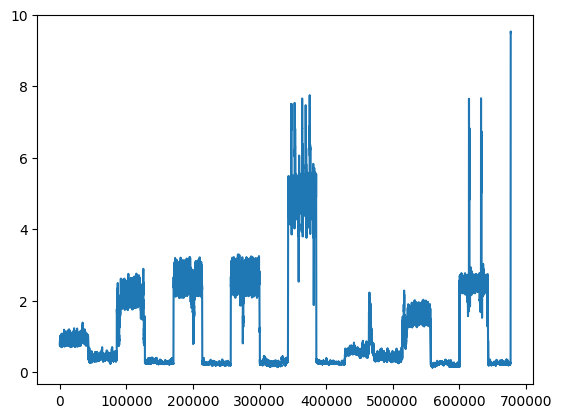

In [8]:
plt.plot(rmse_per_window)
plt.show()

In [10]:
# Get labels for windows.
window_size = 755
threshold = window_size / 2
binary_result = np.convolve(nicla_labels_anol.ravel(), np.ones(window_size, dtype=int), 'valid') > threshold
# Convert boolean array to integers (1s and 0s)
binary_result = binary_result.astype(int)

# Limits to find the threshold
min_rmse = np.min(rmse_per_window)
max_rmse = np.max(rmse_per_window)

# Initialize variables for the best metrics
best_metrics = {'Threshold': None, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'FPR': 0}

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
    predictions = (rmse_per_window > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

Best Threshold: 0.38987919765947454
Best F1 Score: 0.995537261824654
Precision: 0.9928648416233067
Recall: 0.9982241071611127
Accuracy: 0.9954779046050398
FPR: 0.007326990832311552


## XGBoost

In [2]:
# Define a function to create a dataset with rolling windows
def create_dataset(data, window_size, step=1):
    X, y = [], []
    for i in range(0, len(data) - window_size - step + 1, step):
        X.append(data[i:(i + window_size)])  # Window of observations
        y.append(data[i + window_size])      # Next observation as target
    return np.array(X), np.array(y)

# Load the arrays: normal, and anomalous data, and labels.
nicla_nor = np.load('../outputs/nicla_nor.npy')
nicla_anol = np.load('../outputs/nicla_anol.npy')
nicla_labels_anol = np.load('../outputs/nicla_labels_anol.npy')

# Reduce the size of normal data to 10%
total_length = int(nicla_nor.shape[0] * 0.1)
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the reduced data (10% of original)
reduced_nor_data = nicla_nor[:total_length]
train_data = reduced_nor_data[:train_end]
validation_data = reduced_nor_data[train_end:val_end]
test_data = reduced_nor_data[val_end:]

# Scaling
scaler_X = StandardScaler().fit(train_data)
X_train = scaler_X.transform(train_data)
X_val = scaler_X.transform(validation_data)
X_test = scaler_X.transform(test_data)
X_anol = scaler_X.transform(nicla_anol)

# Split the data into input and target using the window size of 755
window_size = 755
X_train, y_train = create_dataset(X_train, window_size=window_size)
X_val, y_val = create_dataset(X_val, window_size=window_size)
X_test, y_test = create_dataset(X_test, window_size=window_size)
X_anol, y_anol = create_dataset(X_anol, window_size=window_size)

In [3]:
# Flatten the input data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize XGBoost regressor and fit.
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, 
                             max_depth=3, seed=42).fit(X_train_flat, y_train)

# Predict on validation set
y_val_pred = xgb_model.predict(X_val_flat)

# Calculate RMSE
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE: {rmse_val}")

Validation RMSE: 0.0615445415588842


We save the model, just in case.
Save or load the model, depends on your needs.

In [21]:
# Save the model
xgb_model.save_model('../outputs/xgb_model.json')
# xgb_model.save_model('../outputs/xgb_model.json')
xgb_model.save_model('../outputs/xgb_model.json')

# Load the model
# loaded_model = xgb.XGBRegressor()
# loaded_model.load_model('xgb_model.json')

In [4]:
# # Flatten the anol data
# X_anol_flat = X_anol.reshape(X_anol.shape[0], -1)

# # Predict on anomalous set
# y_anol_pred_inv = scaler_X.inverse_transform(xgb_model.predict(X_anol_flat))

# Assuming X_anol is already loaded and preprocessed
X_anol_flat = X_anol.reshape(X_anol.shape[0], -1)

# Start the timer
start_time = time.time()

# Predict on the anomalous dataset
y_anol_pred_inv = scaler_X.inverse_transform(xgb_model.predict(X_anol_flat))

# Stop the timer
end_time = time.time()

# Calculate the total inference time
total_inference_time = end_time - start_time

# Calculate the average inference time per sample
average_inference_time_per_sample = total_inference_time / len(X_anol_flat)
print(f"Total inference time: {total_inference_time} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample} seconds")

Total inference time: 3.574069023132324 seconds
Average inference time per sample: 5.274903695951102e-06 seconds


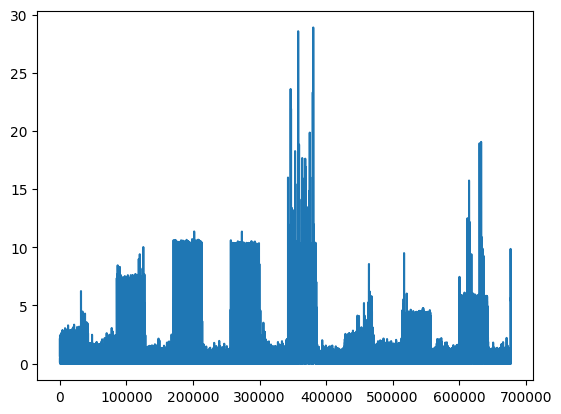

In [40]:
rmse_per_timestep = np.sqrt(np.mean((nicla_anol[window_size:] - y_anol_pred_inv) ** 2, axis=1))
plt.plot(rmse_per_timestep)
plt.show()

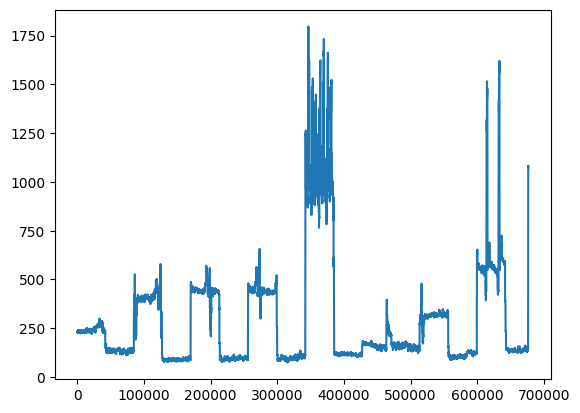

In [41]:
window_size = 755
rmse_sliding_sums = np.convolve(rmse_per_timestep, np.ones(window_size), 'valid')
plt.plot(rmse_sliding_sums)
plt.show()

In [50]:
# Flatten array to 1D.
adjusted_labels = nicla_labels_anol[755:].ravel()  
binary_result = np.convolve(adjusted_labels, np.ones(window_size), 'valid') > (755 / 2)
binary_result = binary_result.astype(int)
print(f"The length of the labels: {len(binary_result)}")
print(f"The length of the windows: {len(rmse_sliding_sums)}")

The length of the labels: 676807
The length of the windows: 676807


In [52]:
# Flatten array to 1D and create binary result
adjusted_labels = nicla_labels_anol[755:].ravel()  
binary_result = np.convolve(adjusted_labels, np.ones(window_size), 'valid') > (755 / 2)
binary_result = binary_result.astype(int)

print(f"The length of the labels: {len(binary_result)}")
print(f"The length of the windows: {len(rmse_sliding_sums)}")

# Limits to find the threshold
min_rmse = np.min(rmse_sliding_sums)
max_rmse = np.max(rmse_sliding_sums)

# Initialize variables for the best metrics
best_metrics = {'Threshold': None, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'FPR': 0}

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
    predictions = (rmse_sliding_sums > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

The length of the labels: 676807
The length of the windows: 676807
Best Threshold: 233.4275311642925
Best F1 Score: 0.9922191822222481
Precision: 0.9850413850206132
Recall: 0.9995023535748577
Accuracy: 0.9920878477911724
FPR: 0.015468423235152849


## One-Class SVM

In [2]:
# Define a function to create a dataset with rolling windows
def create_dataset(data, window_size, step=1):
    X, y = [], []
    for i in range(0, len(data) - window_size - step + 1, step):
        X.append(data[i:(i + window_size)])  # Window of observations
        y.append(data[i + window_size])      # Next observation as target
    return np.array(X), np.array(y)

# Load the arrays: normal, and anomalous data, and labels.
nicla_nor = np.load('../outputs/nicla_nor.npy')
nicla_anol = np.load('../outputs/nicla_anol.npy')
nicla_labels_anol = np.load('../outputs/nicla_labels_anol.npy')

# Reduce the size of normal data to 10%
total_length = int(nicla_nor.shape[0] * 0.1)
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the reduced data (10% of original)
reduced_nor_data = nicla_nor[:total_length]
train_data = reduced_nor_data[:train_end]
validation_data = reduced_nor_data[train_end:val_end]
test_data = reduced_nor_data[val_end:]

# Scaling
scaler_X = StandardScaler().fit(train_data)
X_train = scaler_X.transform(train_data)
X_val = scaler_X.transform(validation_data)
X_test = scaler_X.transform(test_data)
X_anol = scaler_X.transform(nicla_anol)

In [3]:
# Define One-Class SVM model
oc_svm = OneClassSVM(kernel='rbf', gamma='auto')

# Flatten the data if required (One-Class SVM expects 2D input)
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Fit the model
oc_svm.fit(X_train_flattened)

OneClassSVM(gamma='auto')

In [17]:
# Flatten the datasets for prediction
# X_val_flattened = X_val.reshape(X_val.shape[0], -1)
# X_test_flattened = X_test.reshape(X_test.shape[0], -1)
X_anol_flattened = X_anol.reshape(X_anol.shape[0], -1)

# Predict
# val_pred = oc_svm.predict(X_val_flattened)
# test_pred = oc_svm.predict(X_test_flattened)

# Start the timer
start_time = time.time()

# Predict on anomalous data
anol_pred = oc_svm.predict(X_anol_flattened)

# Stop the timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Time taken for predicting on anomalous data: {elapsed_time} seconds")

Time taken for predicting on anomalous data: 607.8188626766205 seconds


In [18]:
# Total number of predictions
num_predictions = X_anol_flattened.shape[0]

# Calculate average inference latency (time per prediction)
average_inference_latency = elapsed_time / num_predictions

print(f"Average inference latency per prediction: {average_inference_latency} seconds")

Average inference latency per prediction: 0.0008960703605349432 seconds


In [7]:
anol_pred = (anol_pred == -1).astype(int)

In [16]:
def calculate_performance_metrics(y_true, y_pred):
    # Compute confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) != 0 else 0

    return accuracy, precision, recall, f1, fpr

# Assuming 'nicla_labels_anol' and 'anol_pred' are defined and have the same length
accuracy, precision, recall, f1, fpr = calculate_performance_metrics(nicla_labels_anol, anol_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"False Positive Rate: {fpr}")

Accuracy: 0.5025872896997859
Precision: 0.6375736710042598
Recall: 0.5061812757263607
F1 Score: 0.564330418995748
False Positive Rate: 0.6352808305719122
